In [1]:
#%%writefile Get_FastPulse.py
#import ROOT
import struct
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats 
import numpy as np
from scipy.fftpack import fft,ifft
from scipy.optimize import curve_fit

In [2]:
#read function
def read_header(run_filename):
    stream = open(run_filename,"rb")
    print("open file ",run_filename)
    pstt = 0.
    FiredD = 0
    V1724_1_DAC = [0]*8
    V1724_1_Tg = [0]*8
    V1724_1_twd = 0
    V1724_1_pretg = 0
    V1724_1_opch = 0
    V1724_2_DAC = [0]*8
    V1724_2_Tg = [0]*8
    V1724_2_twd = 0
    V1724_2_pretg = 0
    V1724_2_opch = 0
    V1721_DAC = [0]*8 #V1724-1 Channel DAC     
    V1721_Tg = [0]*8  #V1724-1 Trigger Settings
    V1721_twd = 0      #V1724-1 Time Window     
    V1721_pretg = 0    #V1724-1 Pre Trigger     
    V1721_opch = 0     #V1724-1 Opened Channel
    V1729_th_DAC = 0
    V1729_posttg = 0
    V1729_tgtype = 0
    V1729_opch = 0
    rstt = 0.
    redt = 0.

    print("***************************Run Header**************************************\n");
    pstt = struct.unpack("d", stream.read(8))[0]
    print("* Program Start Time:",pstt," s.\n");
    FiredD = struct.unpack("I", stream.read(4))[0]
    print("* Fired Devices: ",FiredD," ( V1724-1 | V1724-2 | V1729)\n\n")

    print("* V1724-1 Channel DAC:      ")
    for i in range(8):
        V1724_1_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_1_DAC[i],"\t")
    print("\n")

    V1724_1_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Time Window:  ",V1724_1_twd,"\n")
    V1724_1_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Pre Trigger: ",V1724_1_pretg,"\n")
    V1724_1_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Opened Channel: ",V1724_1_opch,"\n\n")

    #V1724-2 Settings
    print("* V1724-2 Channel DAC:      ");
    for i in range(8):
        V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_2_DAC[i],"\t")
    print("\n")

    V1724_2_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Time Window:  ",V1724_2_twd,"\n")
    V1724_2_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Pre Trigger: ",V1724_2_pretg,"\n")
    V1724_2_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Opened Channel: ",V1724_2_opch,"\n\n")

    V1729_th_DAC = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Threshold DAC:  ",V1729_th_DAC,"\n")
    V1729_posttg = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Post Trigger: ",V1729_posttg,"\n")
    V1729_tgtype = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Trigger Type: ",V1729_tgtype,"\n")
    V1729_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Opened Channel: ",V1729_opch,"\n\n")

    #V1721 Settings
    print("* V1721 Channel DAC:        ")
    for i in range(8):
        V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_2_DAC[i],"\t")
    print("\n")
    V1721_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Time Window: ",V1721_twd,"\n")
    V1721_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Pre Trigger: ",V1721_pretg,"\n")
    V1721_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Opened Channel: ",V1724_1_opch,"\n")

    rstt = struct.unpack("d", stream.read(8))[0]
    print("* Run Start Time: ",rstt," s.\n")
    print("***************************************************************************\n");

    #event header
    Hit_pat = 0
    V1729_tg_rec = 0
    Evt_deadtime = 0
    Evt_starttime = 0
    Evt_endtime = 0
    V1724_1_tgno = 0
    V1724_2_tgno = 0
    V1721_tgno = 0
    V1724_1_tag = 0
    print("current point position: ",stream.tell(),"\n")
    
    return V1724_1_opch,V1724_1_twd

# read an event pulse, output the preamp pulse
def read_event(filename,eventN,V1724_1_opch,V1724_1_twd):
    MAX_WINDOWS = 12000
    EVENT_NUMBER = 10000
    fit_start = 0
    run = int(eventN/EVENT_NUMBER)
    evt = eventN%EVENT_NUMBER+1

    stream = open(filename,"rb")
    
    
    stream.seek(168,0)   #Shift to the evt_num Event
    stream.seek(4*9*(evt-1),1)
    stream.seek(2*V1724_1_opch*V1724_1_twd*(evt-1),1)

    Hit_pat = struct.unpack("I", stream.read(4))[0]
    V1729_tg_rec = struct.unpack("I", stream.read(4))[0]
    Evt_deadtime = struct.unpack("I", stream.read(4))[0]
    Evt_starttime = struct.unpack("I", stream.read(4))[0]
    Evt_endtime = struct.unpack("I", stream.read(4))[0]
    V1724_1_tgno = struct.unpack("I", stream.read(4))[0]
    V1724_2_tgno = struct.unpack("I", stream.read(4))[0]
    V1721_tgno = struct.unpack("I", stream.read(4))[0]
    V1724_1_tag = struct.unpack("I", stream.read(4))[0]
    V1724_1_pulse = np.zeros((V1724_1_opch,V1724_1_twd))
    for k in range(V1724_1_opch):
        for l in range(V1724_1_twd):
            V1724_1_pulse[k][l] = struct.unpack("H", stream.read(2))[0]
    return V1724_1_pulse

# get pulse parameter (by the way of imput func())
def get_par(filename,eventN,V1724_1_opch,V1724_1_twd,func,*args):
    V1724_1_pulse=read_event(filename,eventN,V1724_1_opch,V1724_1_twd)
    return func(V1724_1_pulse[1],*args)


def get_HSfunc(filename,pulser_index,V1724_1_opch,V1724_1_twd):
    L=0
    H=12000
    HSfunc=np.zeros((H-L,),dtype=complex)
    n=len(pulser_index)
    print(n)
    for index in pulser_index:
        V1724_1_pulse=read_event(filename,index,V1724_1_opch,V1724_1_twd)
        v_in=V1724_1_pulse[0][0:2000].mean()-V1724_1_pulse[0]
        v_out=V1724_1_pulse[1][0:2000].mean()-V1724_1_pulse[1]
        #fft
        fftv_in=fft(v_in[L:H])
        fftv_out=fft(v_out[L:H])
       
        HSfunc+=fftv_out          # hit response function
        
    HSfunc=HSfunc/n
    return HSfunc
    
def plot_HSfunc(HSfunc):
    abs_HSfunc=np.abs(HSfunc)
    normal_HSfunc=abs_HSfunc[0:6000]/12000
    rsp=ifft(HSfunc)
    fig, ax = plt.subplots(2,1)
    ax[0].plot(normal_HSfunc[0:10])
    ax[0].set(xlabel='W(Hz)', ylabel='', title='H(w) spectrum')
    ax[0].grid()
    ax[1].plot(rsp)
    ax[1].set(xlabel='t', ylabel='', title='Hit response function ')
    plt.show()
    

def mytanh(x,par0,par1,par2,par3):
    result = par0*(np.tanh(par3*(x-par2))) + par1
    return result

def tanh_generalized(x,par0,par1,par2,par3,par4,par5,par6):
    x=par0*(x-par1)
    x1=par2*x**3+par3*x+par4
    result=par5*((np.exp(x)-np.exp(-x1))/(np.exp(x)+np.exp(-x1)))+par6
    return result

def get_risetime(pulse_,divide_point): #must from small to large
    pulse=(pulse_[3000:3050].mean()-pulse_[3000:3700])
    pulse_max=pulse.max()
    pulse=pulse/float(pulse_max)

    n=len(divide_point)
    
    risetime=np.zeros((n,),dtype=float)
    
    i=0
    for t in np.arange(pulse.size):
        while(i<n and pulse[t]>divide_point[i]):
            #interpolate
            risetime[i]=interpolate(t-1,pulse[t-1],t,pulse[t],divide_point[i])
            #print(t,pulse[t],risetime[i])
            i+=1
##############        plot the interolated point  
    print(divide_point)
    print(risetime)
    fig, ax = plt.subplots(2,1,figsize=(14,10),dpi=500)
    time=np.linspace(0,120,12000)
    ax[0].plot(time[3000:3700], pulse)
    ax[1].plot(time[3320:3370], pulse[320:370])
    ax[1].plot(time[3320:3370], pulse[320:370],'og')
    ax[1].plot((risetime+0.3)/100.+30, divide_point,'or')

    ax[0].set(xlabel='time(us)', ylabel='v',
       title='pre amp pulse')
    ax[1].set(xlabel='time(us)', ylabel='v',
       title='rising edge')
    ax[1].grid()
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.2)
    plt.show()
#     fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/rising_time_par.png")
    
#################

    return risetime[1:n]-risetime[0:n-1]

def interpolate(x1,y1,x2,y2,d):
    return (d-y1)*(x2-x1)/(y2-y1)+x1

def damping(x,A,w,phi,tao,a1,a2,a3):
    exp=np.exp(-x/tao)
    sin=np.sin(w*x+phi)
    return A*sin*exp+a1*x**2+a2*x+a3

def convolution(array1,array2):
    length=array1.size
    if(length!=array2.size):return
    out=np.zeros((length,))
    for tao in range(length):
        for t in range(tao):
            out[tao]+=array1[t]*array2[tao-t]
    return out
    

In [3]:
class PulseLib:
    def __init__(self,nr,nz,length=800,tstep=0.01,fpath="E:/CDEX/ovbb/WaveSimulation/figure/"):
        self.nr=nr
        self.nz=nz
        self.length=length
        self.tstep=tstep
        self.signal_raw=np.zeros((nr,nz,length),dtype=float)
        self.signal_rc=np.zeros((nr,nz,length),dtype=float)
        self.e_path=np.zeros((nr,nz,2,2000),dtype=float)  #(r,z)
        self.h_path=np.zeros((nr,nz,2,2000),dtype=float)  #(r,z)
        self.e_steps_path=np.zeros((nr,nz),dtype=int)       #elec drift path steps 
        self.h_steps_path=np.zeros((nr,nz),dtype=int)       #hole drift path steps 
        self.position_r=np.zeros((nr*nz,),dtype=float)
        self.position_z=np.zeros((nr*nz,),dtype=float)
        self.time=np.linspace(0,tstep*length,length)
        self.fpath=fpath
    def readS(self,filename):
        stream = open(filename,"rb")
        print("open file ",filename)
        for r in range(nr):
            for z in range(nz):
                self.position_r[r*nz+z]=struct.unpack("f", stream.read(4))[0]
                self.position_z[r*nz+z]=struct.unpack("f", stream.read(4))[0]
                for i in range(800):
                    self.signal_raw[r,z,i]=struct.unpack("f", stream.read(4))[0]
                for i in range(800):
                    self.signal_rc[r,z,i]=struct.unpack("f", stream.read(4))[0]
        print("readP done")

    def S_plot(self,position,figname,timel=0,timeh=2):
        P_N=len(position)
        fig, ax = plt.subplots(1,1,figsize=(9,6),dpi=600)
        for i in range(P_N):
            r=position[i][0]
            z=position[i][1]
            index=r*nz+z
            ax.plot(self.time,self.signal_raw[r,z,:],label="R , Z = %.1f, %.2f mm"%(self.position_r[index],self.position_z[index]))
            ax.legend()
        plt.xlim(timel,timeh)
        ax.set(ylabel="Amplitude")
        ax.set(xlabel="time (us)")
        plt.subplots_adjust(left=0.10, bottom=0.08, right=0.95, top=0.95,
                        wspace=0.15, hspace=0.25)
        plt.show()
        fig.savefig(self.fpath+figname)
        
    def readP(self,filename):
        index=0
        r=0
        z=0
        with open(filename,"r") as f_read:
            head=f_read.readline()
            print(head)      
            while True:
                line=f_read.readline()                #read the number of lines
                if not line:
                    break
                    
                num_l=int(line)
                z=int(index%nz)
                r=int((index-z)/nz)
                e_step=0
                h_step=0
                
                for i in range(num_l):
                    line=f_read.readline()
                    n,ex,ey,ez,hx,hy,hz=[float(f) for f in line.split()]
                    if(ex!=0 and ez!=0):
                        self.e_path[r,z,0,i]=ex                                         #0 for r; 1 for z
                        self.e_path[r,z,1,i]=ez                                         #0 for r; 1 for z
                        e_step+=1
                    if(hx!=0 and hz!=0):
                        self.h_path[r,z,0,i]=hx                                         #0 for r; 1 for z                    
                        self.h_path[r,z,1,i]=hz                                         #0 for r; 1 for z   
                        h_step+=1
                index+=1
                self.e_steps_path[r,z]=e_step                
                self.h_steps_path[r,z]=h_step
                
    def P_plot(self,position,figname,x_l=0,x_h=45,y_l=0,y_h=2):
        P_N=len(position)
        fig, ax = plt.subplots(1,1,figsize=(9,6),dpi=600)
        for i in range(P_N):
            r=position[i][0]
            z=position[i][1]
            index=r*nz+z
            e_step=self.e_steps_path[r,z]
            h_step=self.h_steps_path[r,z]
            ax.plot(self.e_path[r,z,0,0:e_step],self.e_path[r,z,1,0:e_step],c="b",label="electron drift path")#,label="R , Z = %.1f, %.2f mm"%(self.position_r[index],self.position_z[index]))
            ax.plot(self.h_path[r,z,0,0:h_step],self.h_path[r,z,1,0:h_step],c="r",label="hole drift path")
        
        #ax.legend()
        plt.xlim(x_l,x_h)
        plt.ylim(y_l,y_h)
        ax.set(ylabel="Z (mm)")
        ax.set(xlabel="R (mm)")
        plt.subplots_adjust(left=0.10, bottom=0.08, right=0.95, top=0.95,
                        wspace=0.15, hspace=0.25)
        plt.show()
        fig.savefig(self.fpath+figname)

        
                
                
                

open file  E:/CDEX/ovbb/WaveSimulation/SimulatedEvents/alpha.bin
readP done
# n ex ey ez hx hy hz

[[0, 2], [6, 2], [12, 2], [18, 2], [24, 2]]


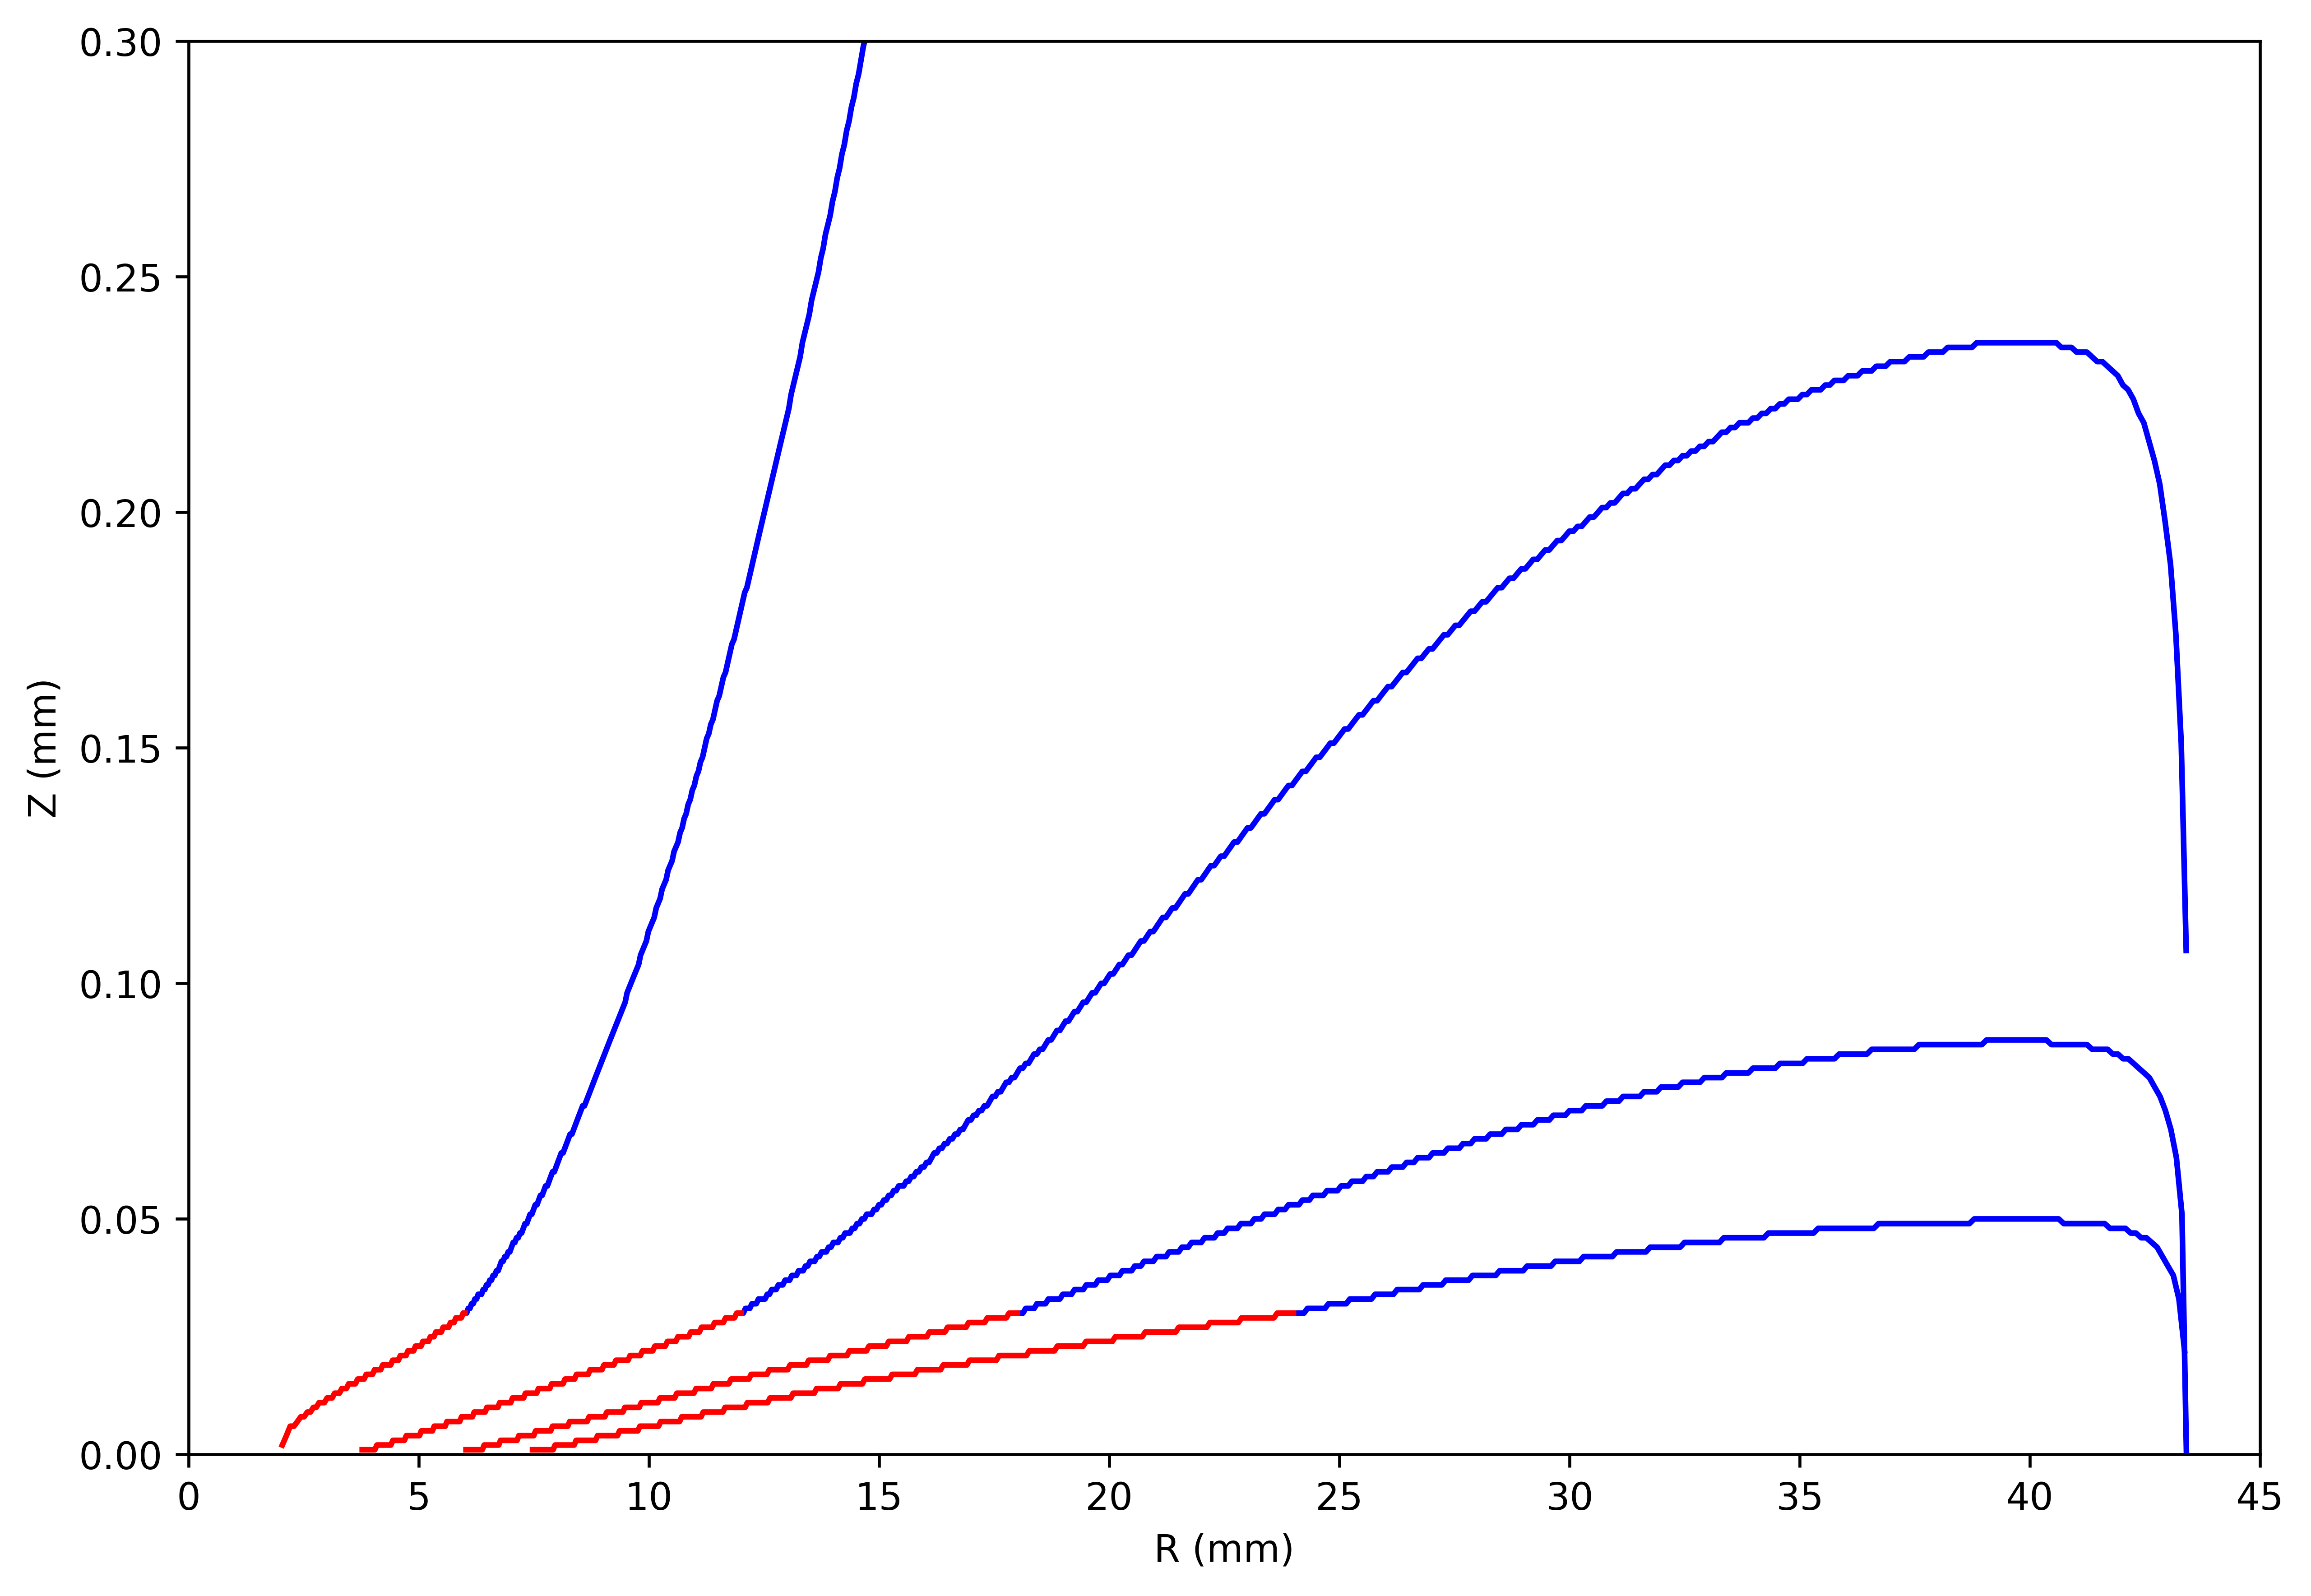

In [124]:
path="E:/CDEX/ovbb/WaveSimulation/SimulatedEvents/"
file="alpha"
Sfilename=path+file+".bin"
Pfilename=path+file+".dat"
nr=44
nz=3
PL_P=PulseLib(nr,nz)
PL_P.readS(Sfilename)
PL_P.readP(Pfilename)

position=[]
for i in range(5):
    position.append([i*6,2])
print(position)
PL_P.P_plot(position,"alpha_path.png",y_h=0.3)

In [61]:
print(np.zeros((2,3,4)))

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


open file  E:/CDEX/ovbb/WaveSimulation/SimulatedEvents/PL_P.bin
current point position:  845856 



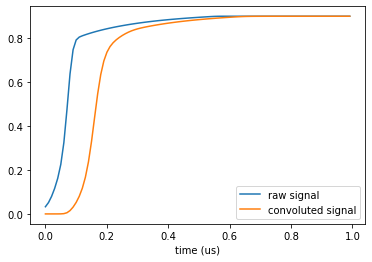

In [4]:
path="E:/CDEX/ovbb/WaveSimulation/SimulatedEvents/"
file="PL_P"
filename=path+file+".bin"
nr=44
nz=3
x=np.zeros((nr*nz,));
y=np.zeros((nr*nz,));

PL_RC_S=np.zeros((800,nz,nr),dtype=float)
PL_Raw_S=np.zeros((800,nz,nr),dtype=float)
current=np.zeros((800,))
time=np.linspace(0,8,800)
ResPulse=np.load("E:/CDEX/ovbb/WaveSimulation/response/ResPulse.npy")


stream = open(filename,"rb")
print("open file ",filename)
for r in range(nr):
    for z in range(nz):
        if (0):
            continue
        else:
            x[r*nz+z] = struct.unpack("f", stream.read(4))[0]
            y[r*nz+z]= struct.unpack("f", stream.read(4))[0]
            for i in range(800):
                PL_Raw_S[i,z,r]=struct.unpack("f", stream.read(4))[0]
            for i in range(800):
                PL_RC_S[i,z,r]=struct.unpack("f", stream.read(4))[0]
            current[1:800]=PL_Raw_S[1:800,z,r]-PL_Raw_S[0:799,z,r]
            
print("current point position: ",stream.tell(),"\n")
np.save(path+file+".npy",PL_Raw_S)
np.save(path+file+"RC.npy",PL_RC_S)
fig=plt.figure()
plt.plot(time[0:100],PL_Raw_S[0:100,1,6])
plt.plot(time[0:100],PL_RC_S[0:100,1,6])
plt.legend(["raw signal","convoluted signal"])
plt.xlabel("time (us)")
#plt.scatter(x,y)
plt.show()
#fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/pulse_w12.png")
# plt.plot(PPC_Plib[:,20,30])
# plt.plot(PPC_signal[:,20,30])
#plt.plot(PPC_Plib[:,20,5])
#plt.plot(PPC_Plib[:,5,30])

# plt.plot(PPC_signal[:,20,20])


open file  E:/CDEX/ovbb/WaveSimulation/icpc_siggen-master/dlsignal.bin
[0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002]
[3.56057317e-05 4.13508606e-05 4.80481831e-05 5.58577231e-05
 6.49596113e-05 7.55523433e-05 8.78484789e-05 1.02067053e-04
 1.18421594e-04 1.37103474e-04 1.58260416e-04 1.81972093e-04
 2.08225290e-04 2.36892971e-04 2.67723488e-04 3.00344109e-04
 3.34282551e-04 3.69004032e-04 4.03959915e-04 4.38637915e-04
 4.72604821e-04 5.05534525e-04 5.37219574e-04 5.67564508e-04
 5.96570317e-04 6.24310225e-04 6.50905829e-04 6.76504918e-04
 7.01263663e-04 7.25334045e-04 7.48855993e-04 7.71952095e-04
 7.94726599e-04 8.17264838e-04 8.39636312e-04 8.61894572e-04
 8.84081412e-04 9.062273

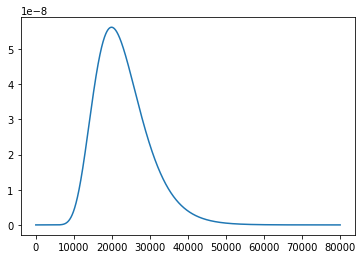

In [86]:
##########bulk pulse:
path="E:/CDEX/ovbb/WaveSimulation/SimulatedEvents/"
file="BEGe_Plib_w12"
filename=path+file+"signal.npy"
Plib=np.load(filename)
##########
path="E:/CDEX/ovbb/WaveSimulation/icpc_siggen-master/"
file="dlsignal"
filename=path+file+".bin"
stream = open(filename,"rb")
print("open file ",filename)

PulseN=struct.unpack("I", stream.read(4))[0]
ngrid =struct.unpack("I", stream.read(4))[0]
nsteps_out=struct.unpack("I", stream.read(4))[0]
nsteps_calc=struct.unpack("I", stream.read(4))[0]



Depth=np.zeros((PulseN,))
Efficiency=np.zeros((PulseN,))
P_old=np.zeros((PulseN,ngrid))
DLsignal=np.zeros((PulseN,nsteps_calc))
DLsignalout=np.zeros((PulseN,800))
OutputS=np.zeros((PulseN,800))
Cdiff=np.zeros((ngrid,))
Cdrif=np.zeros((ngrid,))
Cre=np.zeros((ngrid,))
for i in range(ngrid):
    Cdiff[i]=struct.unpack("f", stream.read(4))[0]
for i in range(ngrid):
    Cdrif[i]=struct.unpack("f", stream.read(4))[0]
for i in range(ngrid):
    Cre[i]=struct.unpack("f", stream.read(4))[0]

for i in range(PulseN):
    Depth[i]=struct.unpack("f", stream.read(4))[0]
    PointR=struct.unpack("I", stream.read(4))[0]
    PointZ=struct.unpack("I", stream.read(4))[0]
    for t in range(nsteps_calc):
        DLsignal[i,t]=struct.unpack("f", stream.read(4))[0]
        DLsignalout[i,int(t/100)]+=DLsignal[i,t]
    OutputS[i,:]=convolution(DLsignalout[i,:],Plib[:,PointZ,PointR])
    for t in range(ngrid):
        P_old[i,t]=struct.unpack("f", stream.read(4))[0]
        
# plt.plot(Cdiff)
# plt.plot(Cdrif)#c drift 好像差了一个数量级
# plt.plot(Cre)
print(Cre)
print(Cdrif)
print(Cdiff)
# print(Cdiff)
# print(Cdrif)
# print(Cre)
# print(Depth)
# print(PulseN)
#print(PointR,PointZ)
#print(P_old)
#for i in range(9):
#plt.plot(P_old[30,:])
plt.plot(DLsignal[40,:])
# print(np.sum(DLsignal[2,:]))
#print(DLsignal[10,:])

#plt.plot(DLsignalout[i,:])
np.save(path+"DLOutS.npy",OutputS)
np.save(path+"DLsignal.npy",DLsignal)


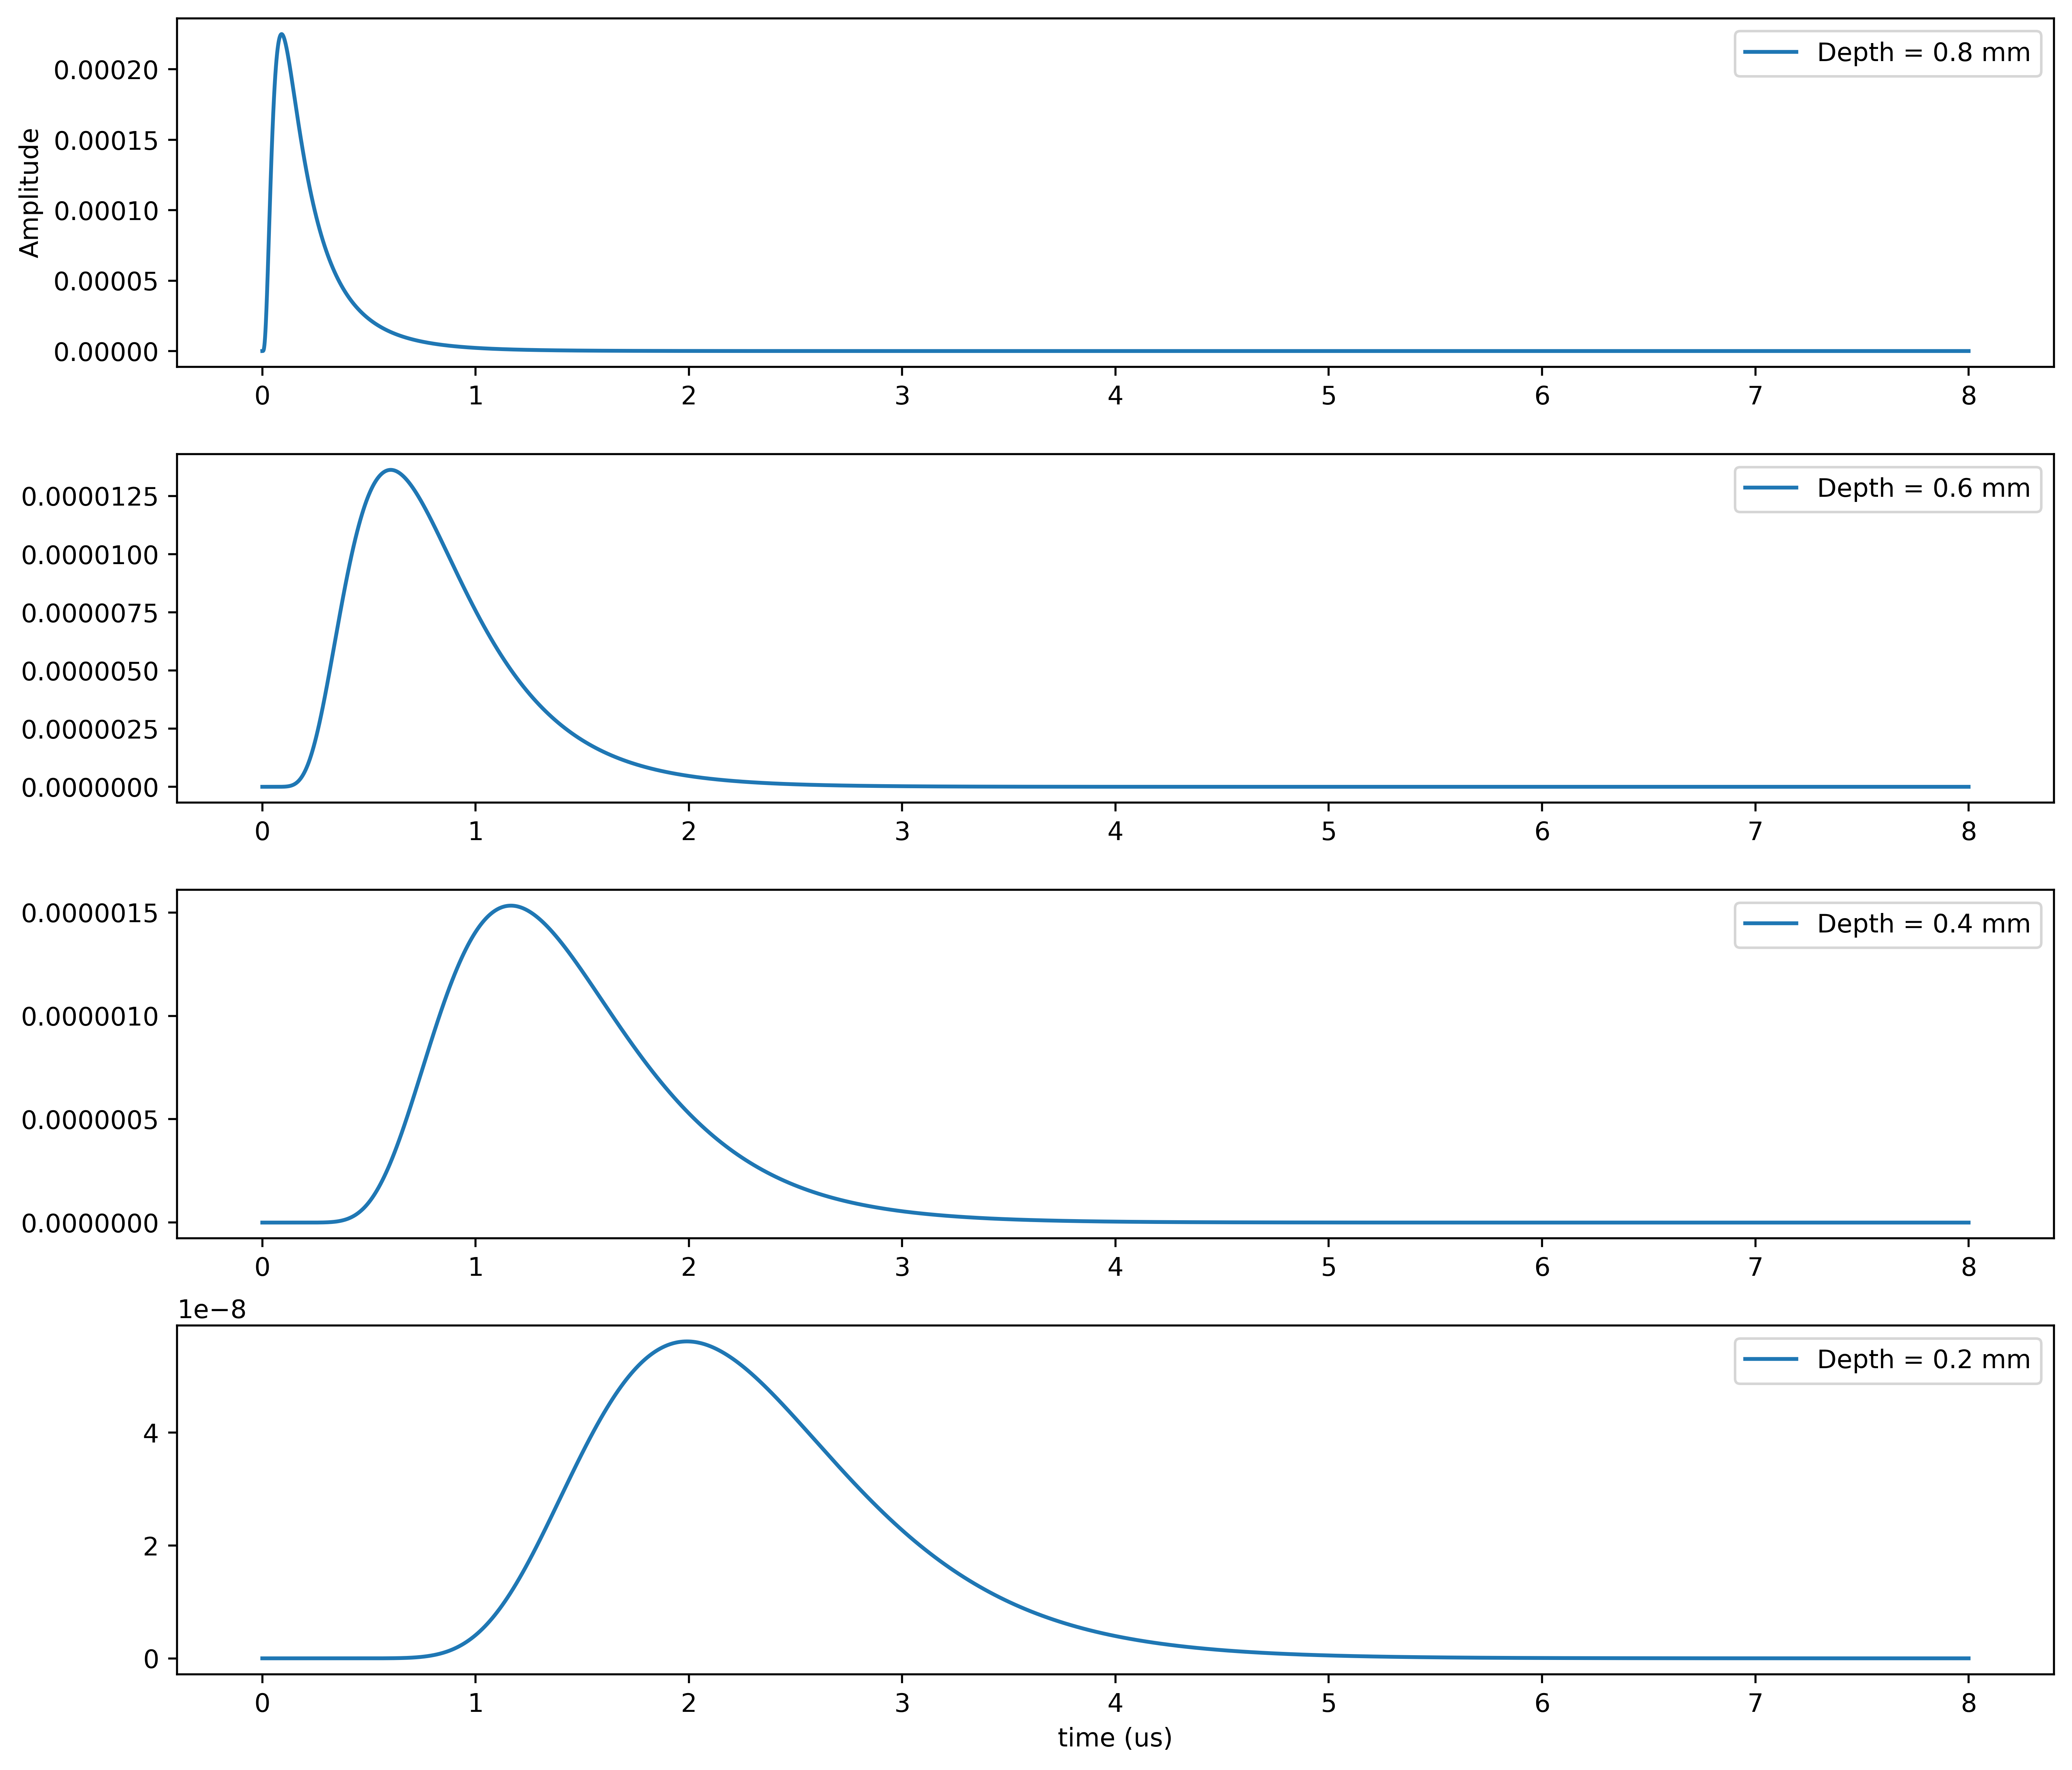

In [87]:
##draw dlsignal
time=np.linspace(0,8,nsteps_calc)
fig, ax = plt.subplots(4,1,figsize=(12,10),dpi=500)
for i in range(1,5):
    ax[(i-1)].plot(time,DLsignal[i*10,:],label="Depth = %.1f mm"%(1-i*10*0.02))
    ax[(i-1)].legend()
ax[0].set(ylabel="Amplitude")
ax[3].set(xlabel="time (us)")
plt.subplots_adjust(left=0.10, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.25)
plt.show()
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/DLsignal_Depth.png")


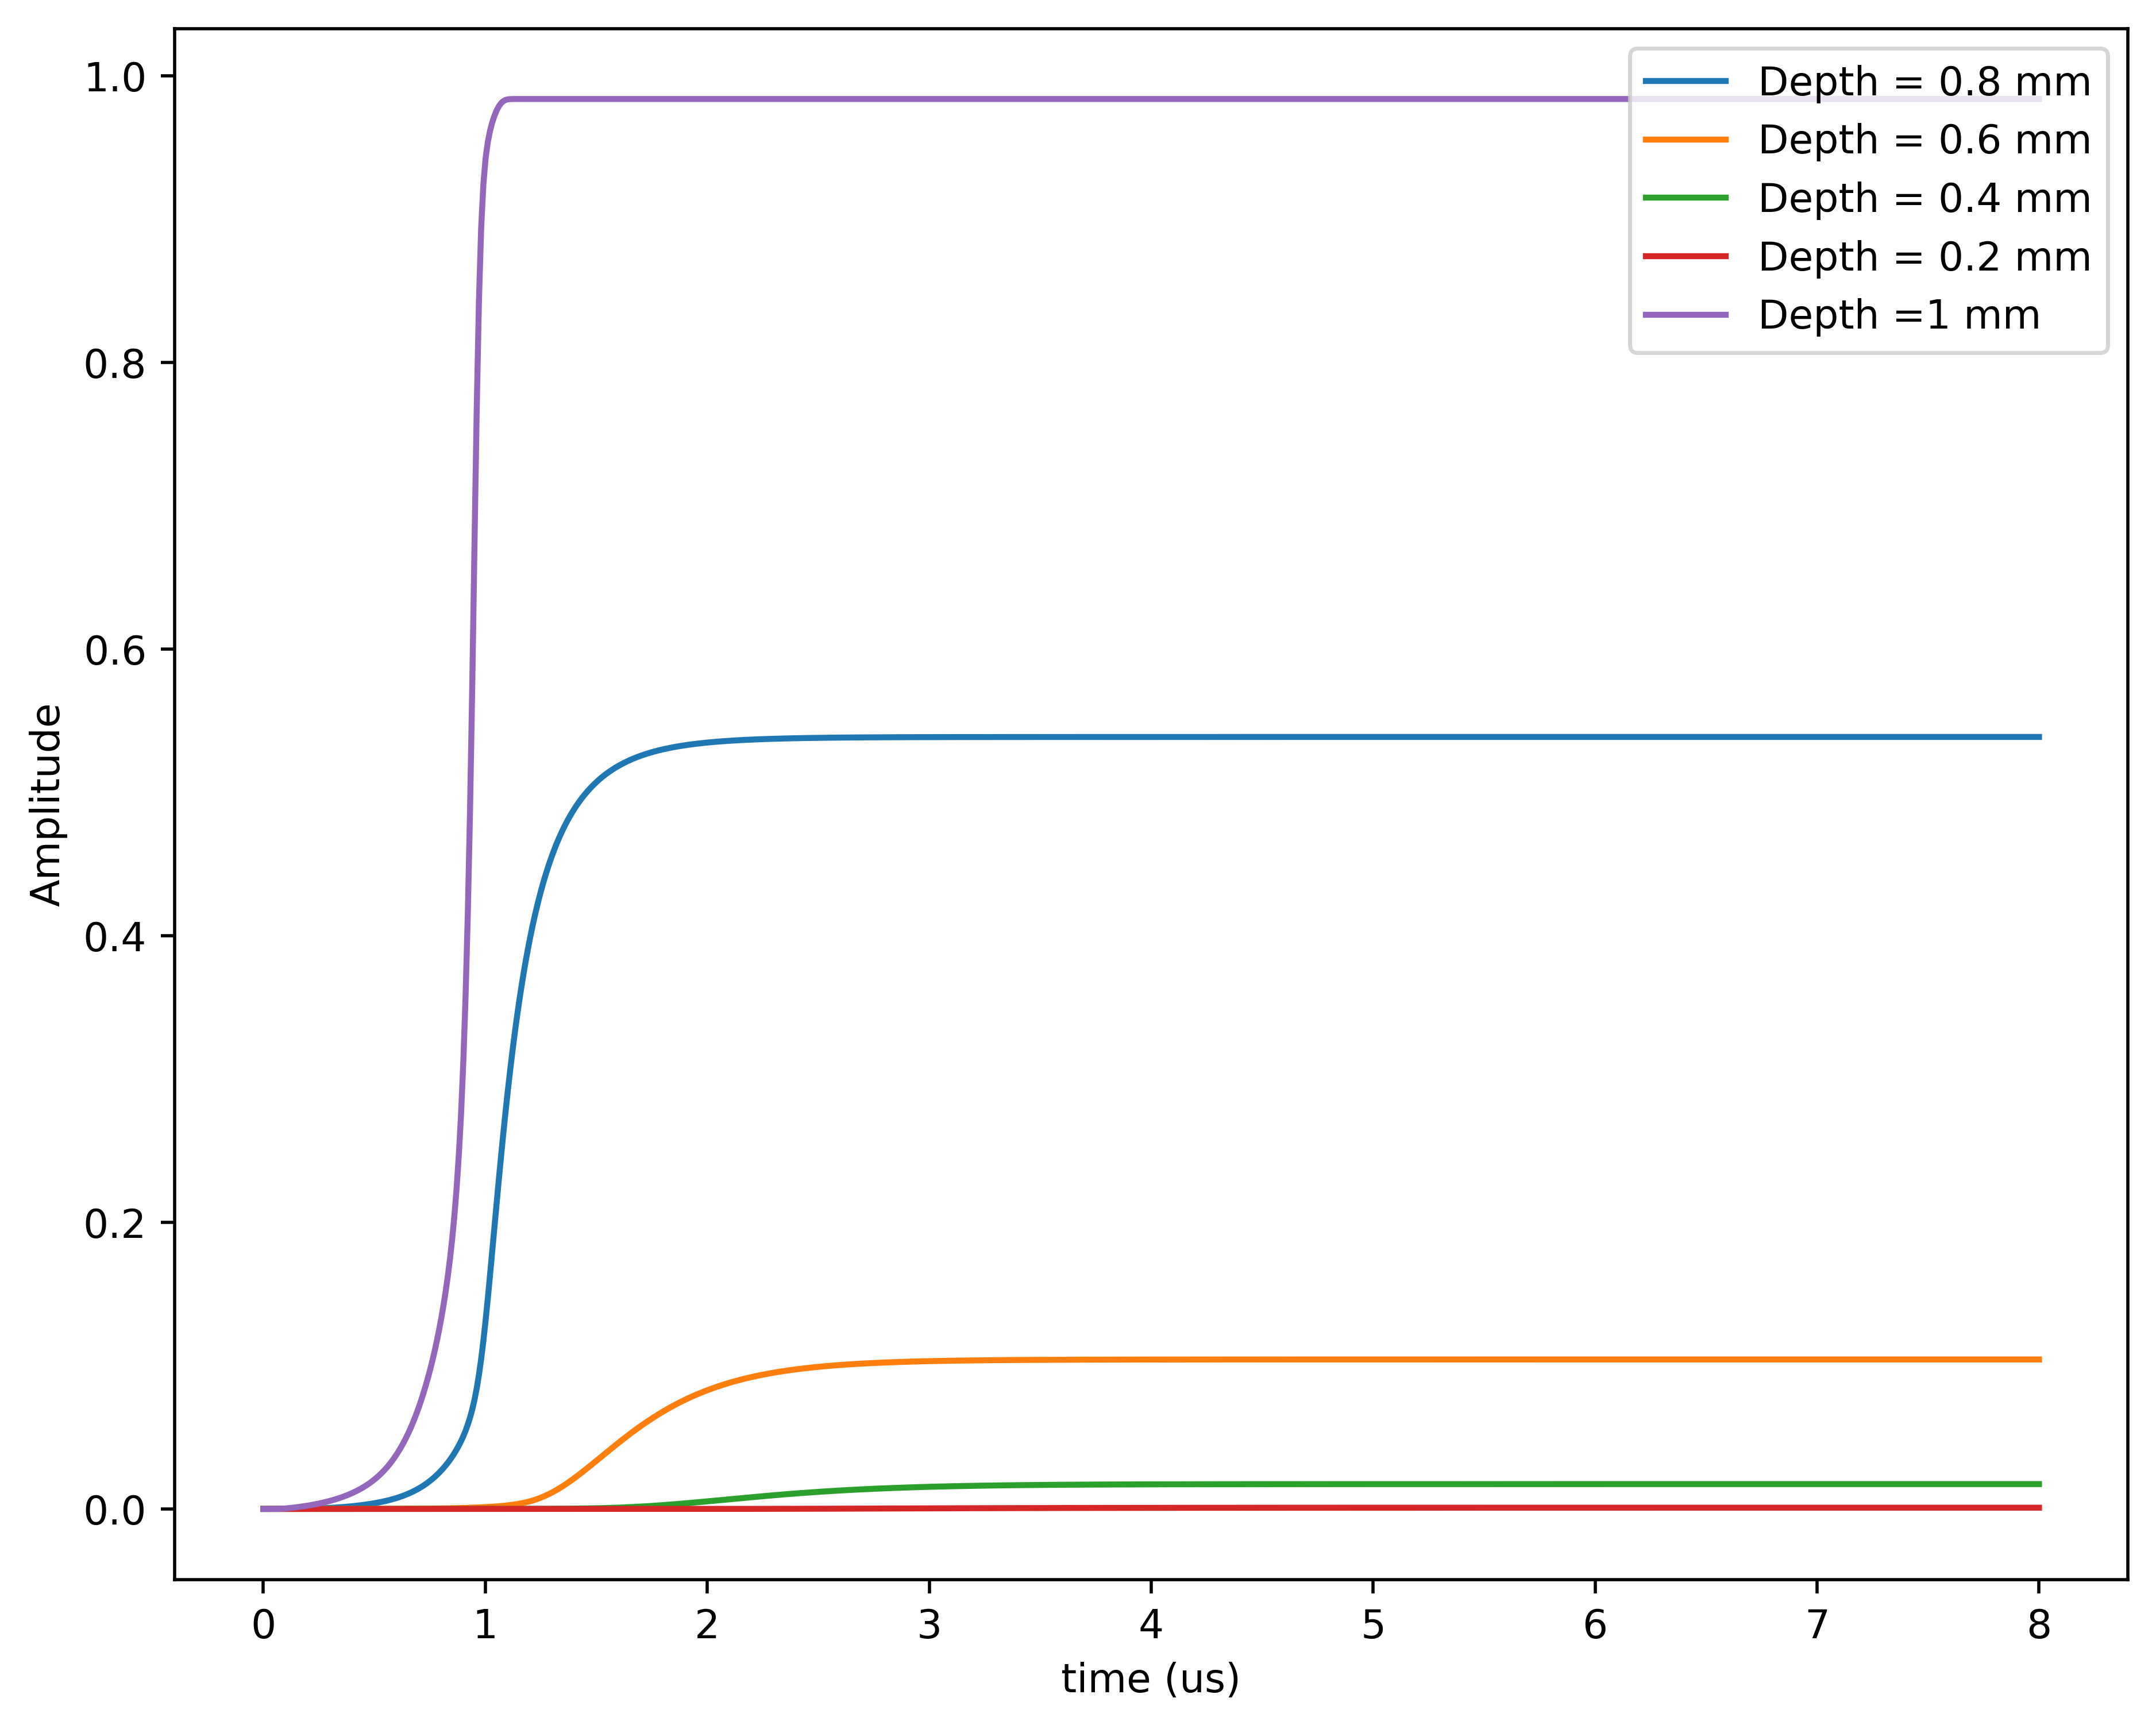

In [89]:
time=np.linspace(0,8,800)
fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=500)
for i in range(1,5):
    ax.plot(time,OutputS[i*10,:],label="Depth = %.1f mm"%(1-i*10*0.02))
    ax.legend()
ax.plot(time,Plib[:,PointZ,PointR],label="Depth =1 mm")
ax.set(xlabel="time (us)",ylabel="Amplitude")
ax.legend(loc="upper right")
plt.subplots_adjust(left=0.10, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.25)
plt.show()
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/DLsignal_out.png")

0 0.9996895813440004
1 0.9993772995428997
2 0.9990584632903456
3 0.9987213545070156
4 0.9983348098166291
5 0.9983348098166291
6 0.9977406240160838
7 0.9898474174243468
8 0.8562265040675987
9 0.6368373866300246
10 0.5475222049966474
11 0.46972601140294845
12 0.4020972553418556
13 0.4020972553418556
14 0.3434258134059646
15 0.2926302715448265
16 0.24874500974272082
17 0.17836219241968126
18 0.15041984976836717
19 0.12648219449315642
20 0.1060198920565205
21 0.1060198920565205
22 0.08856601972677572
23 0.0737117467712411
24 0.06109974758344232
25 0.05041568318267827
26 0.03378512922773596
27 0.027400204311185384
28 0.02205998312380451
29 0.01761358324292073
30 0.01761358324292073
31 0.013932014268570542
32 0.010904121936904225
33 0.008433611950691174
34 0.004841971394406545
35 0.0035839738277864443
36 0.002606870744756618
37 0.0018605825029561244
38 0.0018605825029561244
39 0.0013012915354307741
40 0.0008907656912834728
41 0.0005961131820943239
42 0.0002485063074187794
43 0.00015460541155

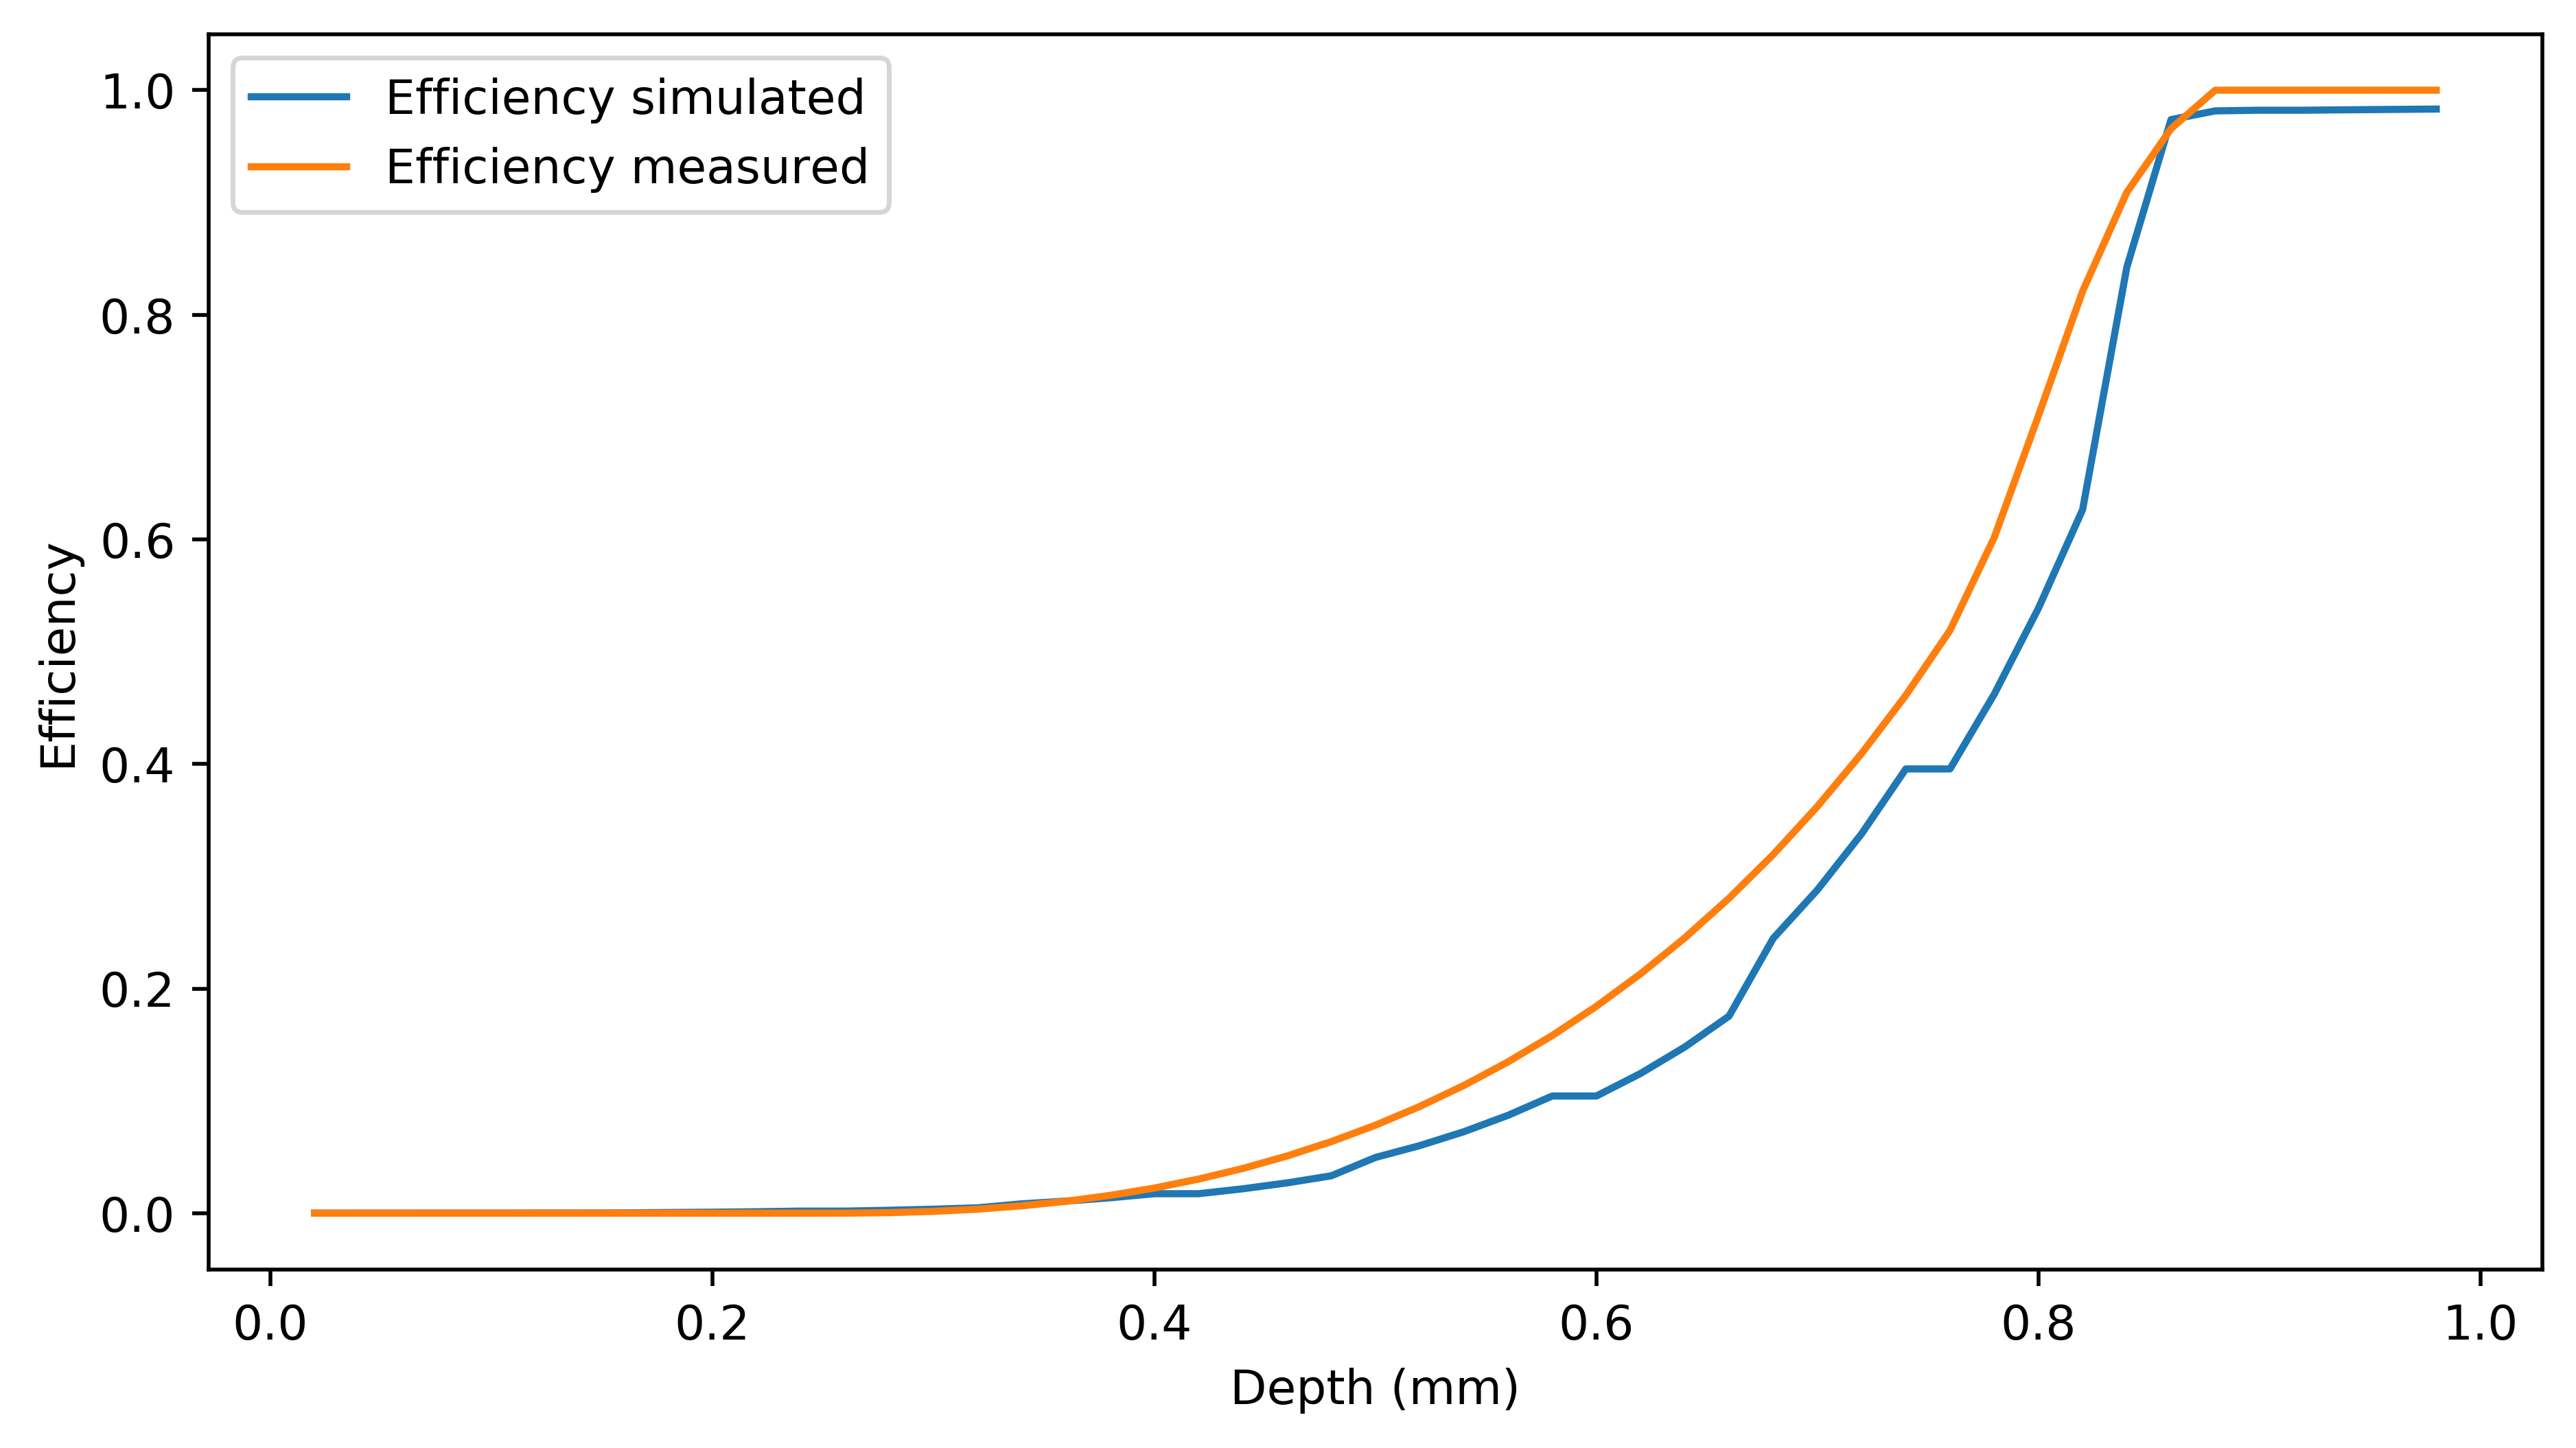

[9.83499133e-01 9.83191908e-01 9.82878236e-01 9.82546587e-01
 9.82166302e-01 9.82166302e-01 9.81581740e-01 9.73816367e-01
 8.42359508e-01 6.26523502e-01 5.38654822e-01 4.62118575e-01
 3.95585099e-01 3.95585099e-01 3.37863869e-01 2.87890985e-01
 2.44716466e-01 1.75473531e-01 1.47983728e-01 1.24433754e-01
 1.04302848e-01 1.04302848e-01 8.71316493e-02 7.25179480e-02
 6.01102057e-02 4.95991742e-02 3.32379586e-02 2.69564397e-02
 2.17027049e-02 1.73283155e-02 1.73283155e-02 1.37063700e-02
 1.07275145e-02 8.29701419e-03 4.76353895e-03 3.52591375e-03
 2.56463389e-03 1.83043084e-03 1.83043084e-03 1.28019676e-03
 8.76318734e-04 5.86437737e-04 2.44460556e-04 1.52080990e-04
 9.22667649e-05 5.46407018e-05 5.46407018e-05 3.17009897e-05
 1.82503534e-05 1.08862680e-05]


In [94]:
def EffiM(x):
    eff=np.zeros((x.size,))
    for i in range(x.size):
        if(x[i]>0.25 and x[i]<0.75):
            eff[i]=2**(((x[i]-0.25)/(0.88-0.25))**2.4)-1
        elif(x[i]>0.75 and x[i]<0.88):
            eff[i]=0.31*np.tanh(18.51*x[i]-14.84)+0.72
        elif(x[i]>0.88):
            eff[i]=1
    return eff

fig, ax = plt.subplots(1,1,figsize=(8,4),dpi=500)
efficiencyM=EffiM(Depth)
efficiency=np.zeros((PulseN,))
for i in range(0,PulseN):
    efficiency[i]=np.max(OutputS[i])
    print(i,np.sum(DLsignal[i,:]))
ax.plot(Depth[1:PulseN],efficiency[1:PulseN],label="Efficiency simulated")
ax.plot(Depth[1:PulseN],efficiencyM[1:PulseN],label="Efficiency measured")

ax.set(xlabel="Depth (mm)",ylabel="Efficiency")
plt.subplots_adjust(left=0.10, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.25)
ax.legend()
plt.show()
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/DLEfficiency.png")
print(efficiency)

In [14]:
#convolution
path="E:/CDEX/ovbb/WaveSimulation/SimulatedEvents/"
filename=path+file+"signal.npy"
PPC_Plib=np.load(filename)
respons=np.zeros((800,))
# for i in range(800):
#     if (i<37.5):
#         respons[i]=i/37.5
#     else:
#         respons[i]=1
# #signal=np.convolve(respons,PPC_Plib[:,60,29],"same")
# pulse=PPC_Plib[:,60,29]
# signal=np.zeros((800,))
# current=np.zeros((800,))
# current[1:800]=pulse[1:800]-pulse[0:799]
# N=800
# for tao in range(800):
#     for t in range(800):
#         if(tao-t>=0):
#             signal[tao]+=respons[tao-t]*current[t]

# fftc=fft(current)
# fftr=fft(respons)
# signal=ifft(fftc*fftr)
i=0
nr=44
nz=28
for r in range(nr):
    for z in range(nz):
        i=0
drift_time=np.zeros((nr,nz))
drift_time2=np.zeros(((nr*nz,))# for r in range(nr):
#     for z in range(nz):
#         t_drift=0
#         i=0
#         while(i<800):
#             if (PPC_Plib[i,z,r]>0.001 and PPC_Plib[i,z,r]<0.1):
#                 t_drift+=10
#             elif (PPC_Plib[i,z,r]>0.1):
#                 break
#             i+=1
#         drift_time[r,z]=t_drift
#         drift_time2[r*nz+z]=t_drift
        
l=0
h=800

# plt.plot((signal[l:h]))
# plt.plot(current[l:h])
# plt.plot(pulse[l:h])




SyntaxError: invalid syntax (<ipython-input-14-0962971bb375>, line 45)

In [16]:
#convolution
path="E:/CDEX/ovbb/WaveSimulation/SimulatedEvents/"
filename=path+file+"signal.npy"
PPC_Plib=np.load(filename)
respons=np.zeros((800,))
nr= 44
nz= 28
for r in range(nr):
    for z in range(nz):
        t_drift=0

In [ ]:
#read the header
path="G:/WaveResponse/"
#filename = path+"20200712_run2_pulser_ph1000_2_3106D_BEGe_2026_6us_0.5_5_FADC_RAW_Data_0.bin"
filename = path+"20200712_run6_pulser_ph200_2_3106D_BEGe_2026_6us_0.5_5_FADC_RAW_Data_0.bin"
V1724_1_opch,V1724_1_twd=read_header(filename)

In [28]:
#save the rising edge pulse as .npy file
front_L=40
after_L=60
rising_L=front_L+after_L

rising_edge_pulse=np.zeros((rising_L,10000),dtype=float)
rising_time_point=np.zeros((10000,))
print(rising_edge_pulse.shape)
pulser_index=[]
j=0
for i in range(30000):
    if (j<10000):
        V1724_1_pulse=read_event(filename,i,V1724_1_opch,V1724_1_twd)
        if ((V1724_1_pulse[0][0:100].mean()-V1724_1_pulse[0].min())>10000):
            pulser_index.append(i)
            pulse=V1724_1_pulse[1][0:1000].mean()-V1724_1_pulse[1]
            t0=np.argmin(pulse)
            if(t0>3000 and t0<4000):
                Pmax=pulse[t0:t0+after_L].max()
                rising_edge_pulse[:,j]=pulse[t0-front_L:t0+after_L]/Pmax
                rising_time_point[j]=t0
                j+=1 
                if(j%1000==0):
                    print('j = ',j)
# np.save("E:/CDEX/ovbb/WaveSimulation/response/Pulser_Index.npy",pulser_index)
# np.save("E:/CDEX/ovbb/WaveSimulation/response/rising_edge_pulse.npy",rising_edge_pulse)
# np.save("E:/CDEX/ovbb/WaveSimulation/response/rising_time_point.npy",rising_time_point)

(100, 10000)
j =  1000
j =  2000
j =  3000
j =  4000
j =  5000
j =  6000
j =  7000
j =  8000
j =  9000
j =  10000


(40,)


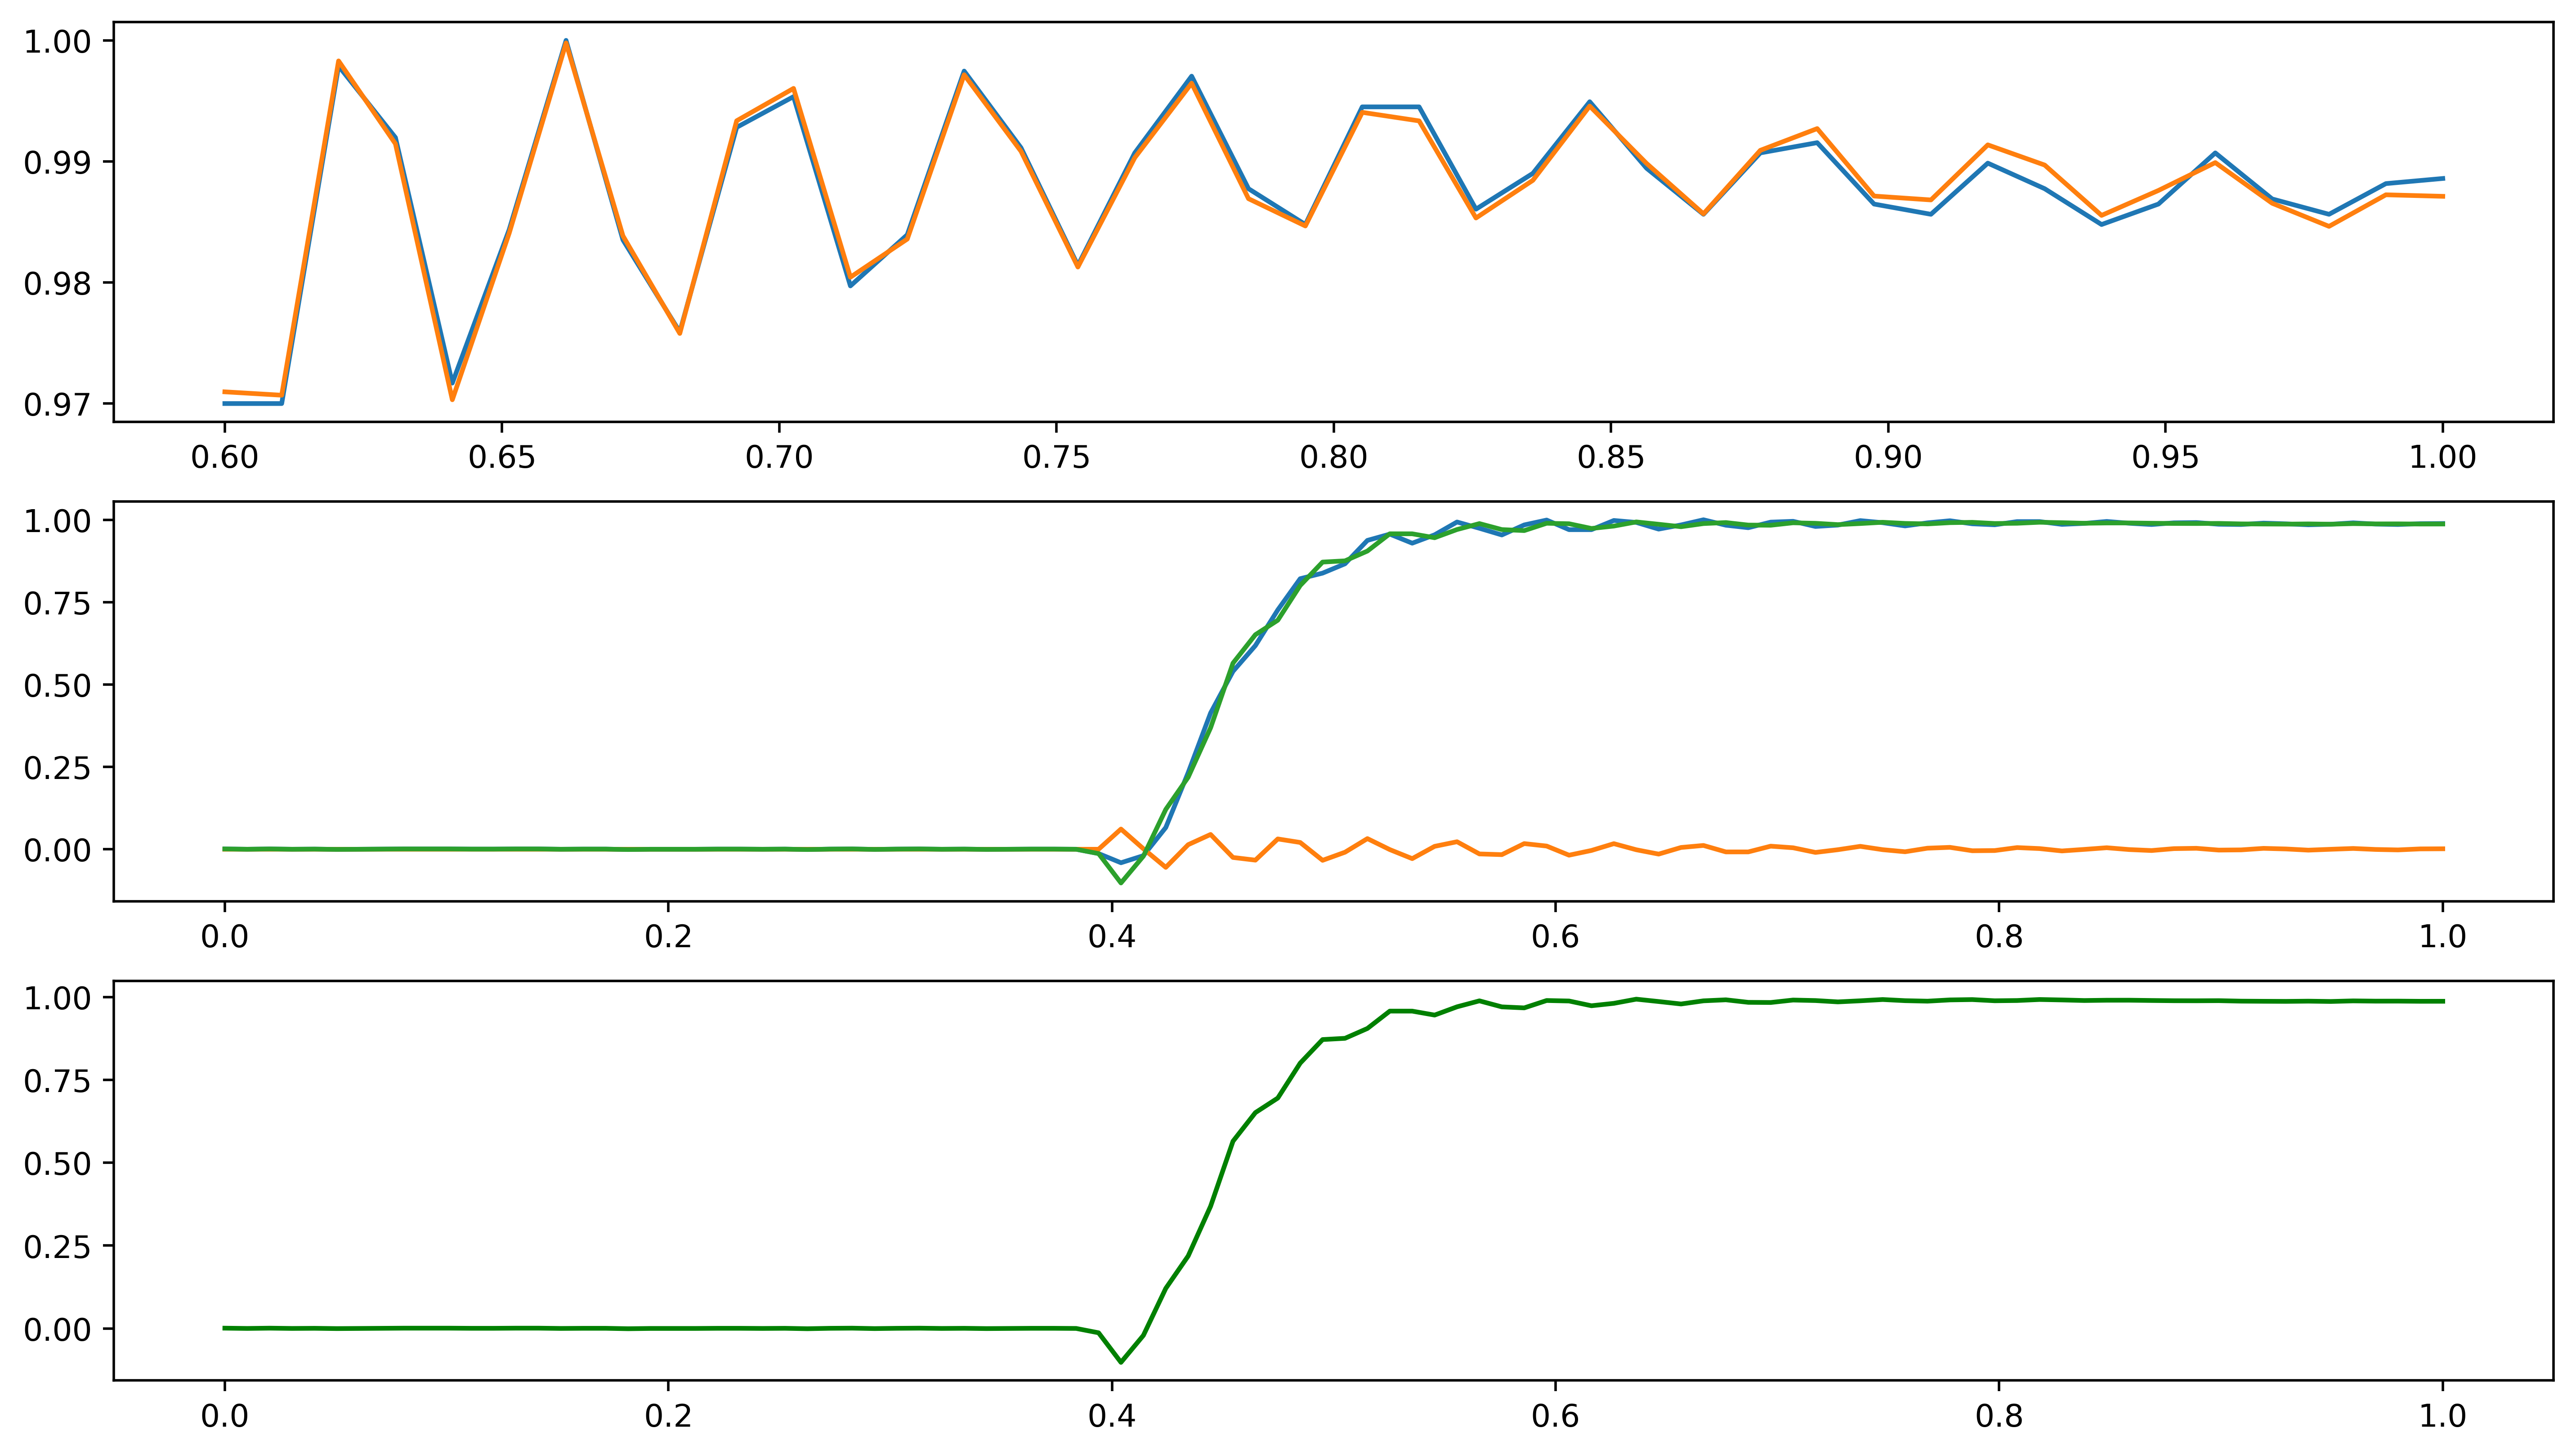

[ 1.95240505e-02  1.69041005e+02  3.78829294e+00  1.72481464e-01
 -1.42856311e-01  6.45228995e-02  9.82712896e-01]


In [86]:
# rising_edge_pulse=np.zeros((100,10),dtype=float)
# print(rising_edge_pulse[0,:])
rising_edge_pulse=np.load("E:/CDEX/ovbb/WaveSimulation/response/rising_edge_pulse.npy")
damping_curve=rising_edge_pulse[60:100,1]
par_bounds_damp=([0.01,100,0,0.1,-0.2,-1,0.8],[0.02,300,7,0.4,0,1,1])
time=np.linspace(0,0.4,40)
popt,pcov=curve_fit(damping,time,damping_curve,bounds=par_bounds_damp)
fit_sig_damp=damping(time,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
print(fit_sig_damp.shape)
damping_component=np.zeros((100,),dtype=float)
damping_component[40:100]=damping(np.linspace(-0.2,0.4,60),popt[0],popt[1],popt[2],popt[3],0,0,0)
fig, ax = plt.subplots(3,1,figsize=(14,8),dpi=500)
ax[0].plot(time+0.6,damping_curve)
ax[0].plot(time+0.6,fit_sig_damp)
ax[1].plot(np.linspace(0,1,100),rising_edge_pulse[:,1])
ax[1].plot(np.linspace(0,1,100),damping_component)
ax[1].plot(np.linspace(0,1,100),rising_edge_pulse[:,1]-damping_component)
ax[2].plot(np.linspace(0,1,100),rising_edge_pulse[:,1]-damping_component,"g")

plt.show()
print(popt)


In [23]:
P_index=np.load("E:/CDEX/ovbb/WaveSimulation/response/Pulser_Index.npy")
risetime=np.zeros((len(P_index),3),dtype=float)
for i in range(len(P_index)):
    risetime[i][:]=get_par(filename,P_index[i],V1724_1_opch,V1724_1_twd,get_risetime,[0.05,0.1,0.9,0.95])


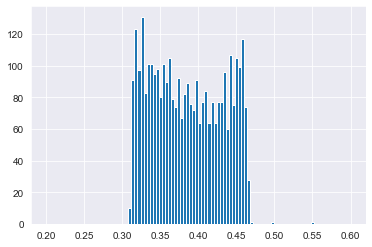

In [55]:
# print(len(P_index))
# sns.set_style("darkgrid")

# sns.distplot(risetime[:,0],bins=20,fit=stats.norm,kde=False)

#print(risetime[:,0].shape)
#plt.hist(x=risetime[:,1],bins=100,range=(8.2,8.4))
#plt.hist(x=risetime[:,2],bins=100,range=(0.5,2))
plt.hist(x=risetime[:,0],bins=100,range=(0.2,0.6))

plt.show()
#print(risetime[0:10,0])

In [64]:
path="G:/WaveResponse/"
#filename = path+"20200712_run2_pulser_ph1000_2_3106D_BEGe_2026_6us_0.5_5_FADC_RAW_Data_0.bin"
filename = path+"20200712_run6_pulser_ph200_2_3106D_BEGe_2026_6us_0.5_5_FADC_RAW_Data_0.bin"
V1724_1_opch,V1724_1_twd=read_header(filename)

open file  G:/WaveResponse/20200712_run6_pulser_ph200_2_3106D_BEGe_2026_6us_0.5_5_FADC_RAW_Data_0.bin
***************************Run Header**************************************

* Program Start Time: 3677386963.1454725  s.

* Fired Devices:  1  ( V1724-1 | V1724-2 | V1729)


* V1724-1 Channel DAC:      
7343 	
7343 	
59343 	
57343 	
37343 	
37343 	
57343 	
57343 	


* V1724-1 Time Window:   12000 

* V1724-1 Pre Trigger:  4000 

* V1724-1 Opened Channel:  2 


* V1724-2 Channel DAC:      
57343 	
57343 	
57343 	
57343 	
57343 	
8192 	
47343 	
47343 	


* V1724-2 Time Window:   8000 

* V1724-2 Pre Trigger:  2000 

* V1724-2 Opened Channel:  4 


* V1729 Threshold DAC:   2060 

* V1729 Post Trigger:  0 

* V1729 Trigger Type:  1 

* V1729 Opened Channel:  4 


* V1721 Channel DAC:        
58000 	
52000 	
57343 	
8192 	
8192 	
8192 	
8192 	
47343 	


* V1721 Time Window:  12000 

* V1721 Pre Trigger:  12000 

* V1721 Opened Channel:  2 

* Run Start Time:  3677386963.1616664  s.

******

In [73]:
#search the pulser pulse index(because some event is bkg)
pulser_index=[]
for i in range(100):
    V1724_1_pulse=read_event(filename,i,V1724_1_opch,V1724_1_twd)
    if ((V1724_1_pulse[0][0:100].mean()-V1724_1_pulse[0].min())>10000):
        pulser_index.append(i)

print(len(pulser_index))
print(pulser_index)
#HSfunc=get_HSfunc(filename,pulser_index, V1724_1_opch,V1724_1_twd)

31
[9, 11, 13, 16, 19, 20, 24, 25, 30, 33, 35, 38, 41, 45, 48, 49, 53, 55, 60, 62, 67, 71, 74, 78, 81, 84, 86, 88, 89, 94, 96]


In [21]:
Pulser_Index=np.array(pulser_index)
np.save("E:/CDEX/ovbb/WaveSimulation/response/Pulser_Index.npy",Pulser_Index)
np.save("E:/CDEX/ovbb/WaveSimulation/response/HSfunc.npy",HSfunc)

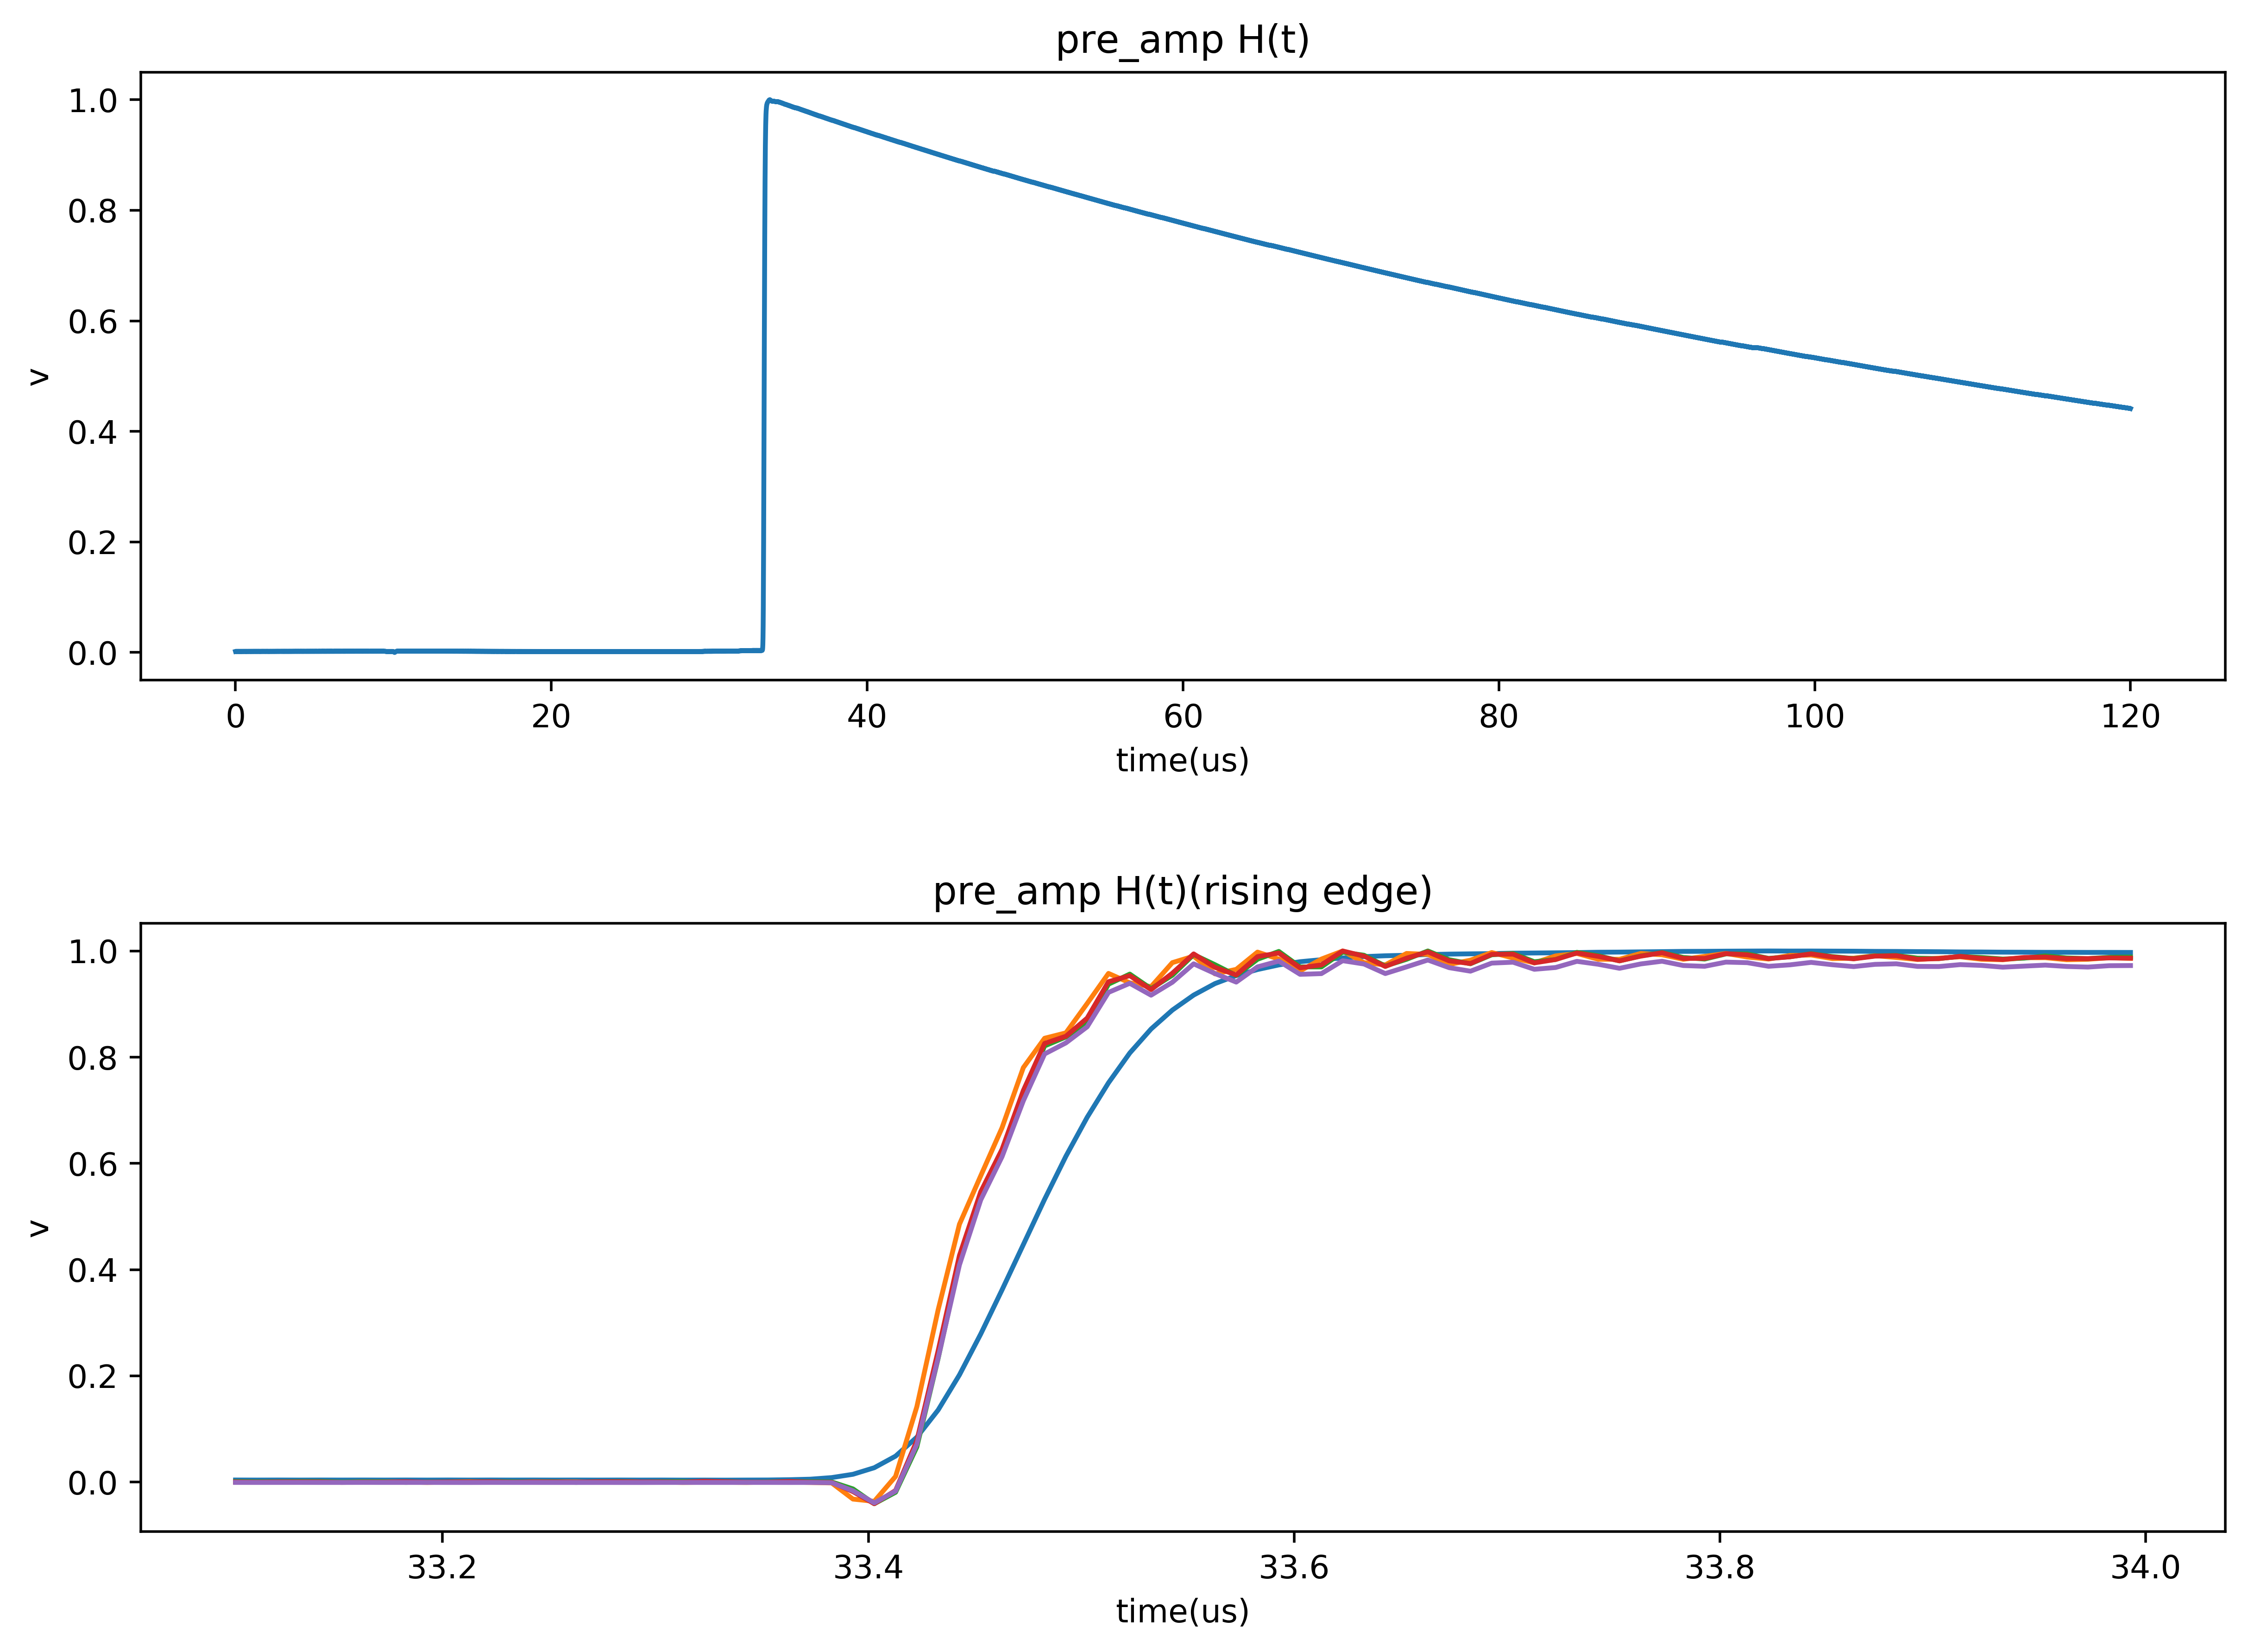

0.002116349966476866 0.002130684947577662


In [16]:
HSfunc=np.load("E:/CDEX/ovbb/WaveSimulation/response/HSfunc.npy")
P_index=np.load("E:/CDEX/ovbb/WaveSimulation/response/Pulser_Index.npy")
result=ifft(HSfunc)
norm_result=np.abs(result/result.max())
PlotRangeL=3310
PlotRangeH=3400
fig, ax = plt.subplots(2,1,figsize=(10,7),dpi=500)
time=np.linspace(0,120,12000)
ax[0].plot(time,norm_result)
ax[0].set(xlabel='time(us)', ylabel='v',
       title='pre_amp H(t)')
ax[1].plot(time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],label="pre amp raw pulse")
ax[1].set(xlabel='time(us)', ylabel='v',
       title='pre_amp H(t)(rising edge)')

t0=3340
############
ave=np.zeros((PlotRangeH-PlotRangeL,),dtype=float)
for i in range(0,200):
    V1724_1_pulse=read_event(filename,P_index[i],V1724_1_opch,V1724_1_twd)
    pulse_i=V1724_1_pulse[1][0:1000].mean()-V1724_1_pulse[1]
    pulse_i_norm=pulse_i/pulse_i.max()
    delta_t0=np.argmin(pulse_i_norm)-t0
    if (i<3):
        ax[1].plot(time[PlotRangeL:PlotRangeH],pulse_i_norm[PlotRangeL+delta_t0:PlotRangeH+delta_t0])
    ave=ave+pulse_i_norm[PlotRangeL+delta_t0:PlotRangeH+delta_t0]
ave=ave/200
ax[1].plot(time[PlotRangeL:PlotRangeH],ave)
    
############
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.4)
plt.show()
print(norm_result[0:1000].mean(),norm_result[1000:2000].mean())
#fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/rising_edge.png")


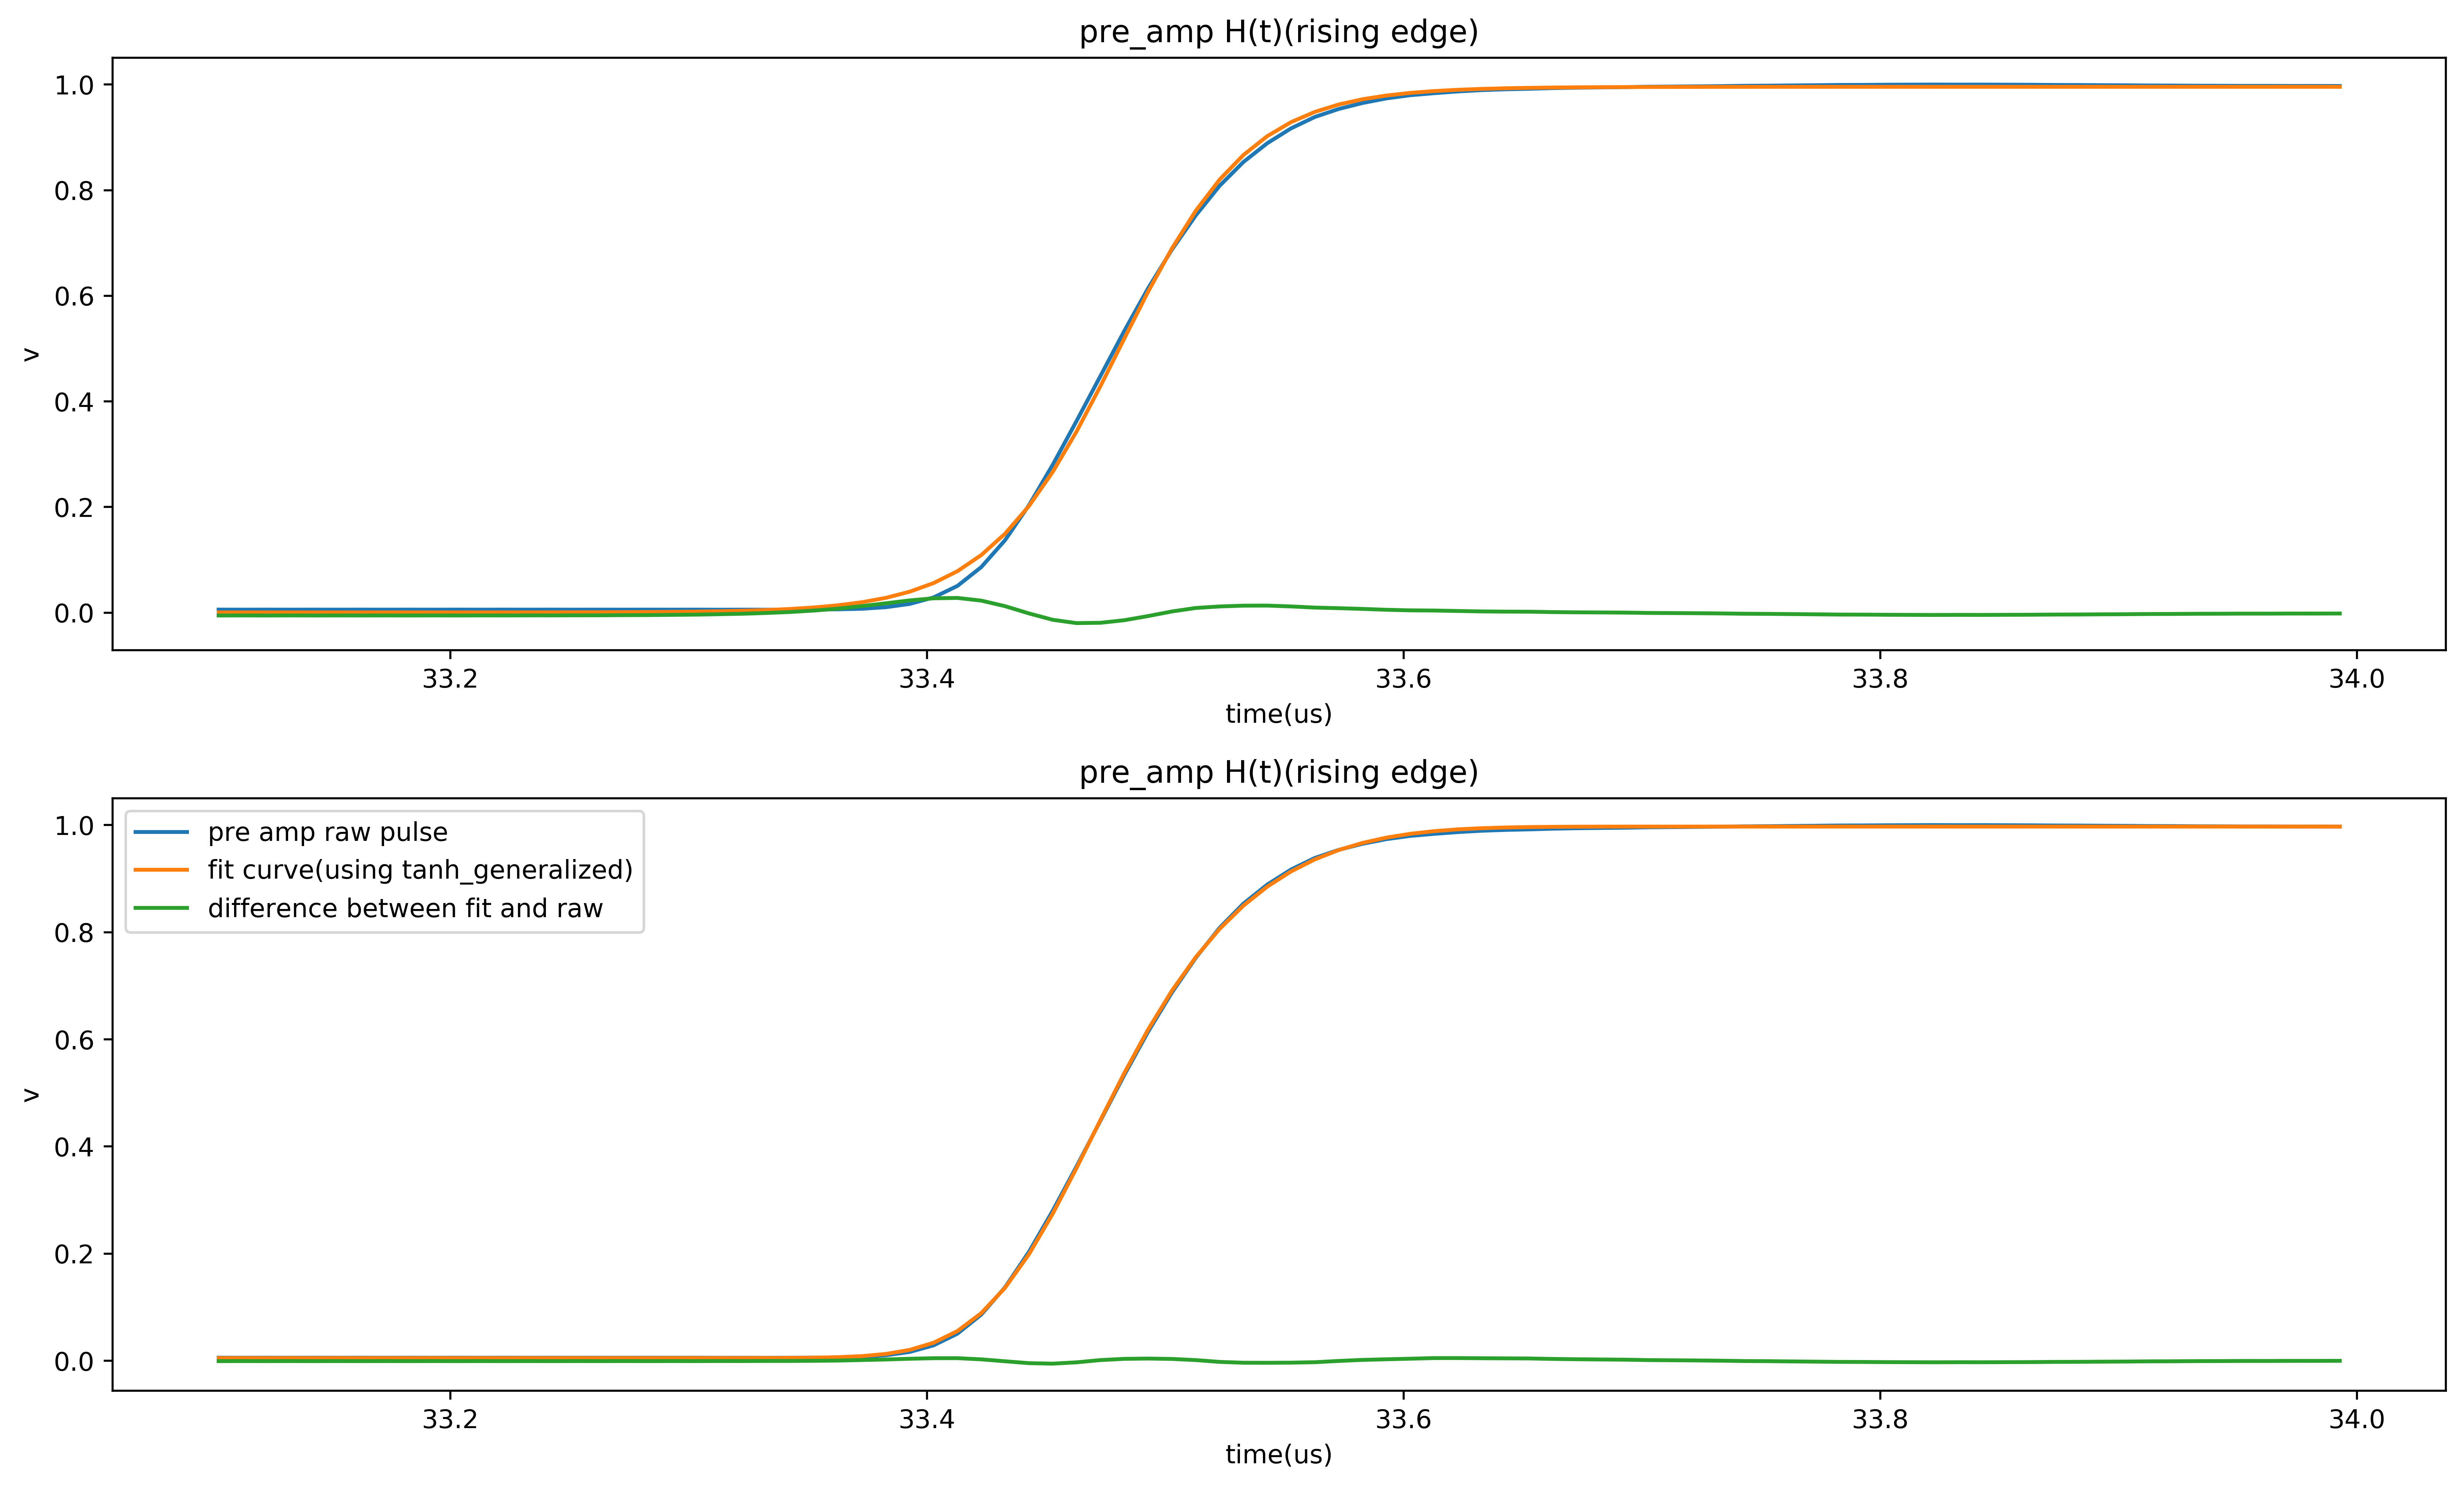

[11.18892193 33.52269887  0.50645722  1.77871288  1.4306073   0.49600508
  0.50118268]


In [9]:
# imput the norm_result here
result=ifft(HSfunc)
norm_result=result/result.max()

#set the range of fit and plot here(time)
PlotRangeL=3310
PlotRangeH=3400

#set plot set here
fig, ax = plt.subplots(2,1,figsize=(14,8),dpi=500)
time=np.linspace(0,120,12000)

# ax[0].plot(time,norm_result)
# ax[0].set(xlabel='time(us)', ylabel='v',
#        title='pre_amp H(t)')
ax[0].plot(time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],label="pre amp raw pulse")
ax[0].set(xlabel='time(us)', ylabel='v',
       title='pre_amp H(t)(rising edge)')

ax[1].plot(time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],label="pre amp raw pulse")
ax[1].set(xlabel='time(us)', ylabel='v',
       title='pre_amp H(t)(rising edge)')

par_bounds_tanh=([0.48,0.48,33.4,10],[0.52,0.52,33.6,20])

popt,pcov=curve_fit(mytanh,time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],bounds=par_bounds_tanh)
fit_sig_tanh=mytanh(time[PlotRangeL:PlotRangeH],popt[0],popt[1],popt[2],popt[3])
ax[0].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanh,label="fit curve(using tanh)")
ax[0].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanh-norm_result[PlotRangeL:PlotRangeH],label="difference between fit and raw")
plt.legend()
#curve fit
par_bounds_tanhg=([10,33.4,0,0,0,0.4,0.4],[20,33.6,2,10,10,0.6,0.6])
popt,pcov=curve_fit(tanh_generalized,time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],bounds=par_bounds_tanhg)
fit_sig_tanhg=tanh_generalized(time[PlotRangeL:PlotRangeH],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
ax[1].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanhg,label="fit curve(using tanh_generalized)")
ax[1].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanhg-norm_result[PlotRangeL:PlotRangeH],label="difference between fit and raw")

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.25)
plt.legend()
plt.show()
#leg = ax[1].legend(loc='upper left', fancybox=True, shadow=True)
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/rising_fit_compare.png")
print(popt)#,pcov)
#HSfunc.save()

In [18]:
#np.savetxt("E:/CDEX/ovbb/WaveSimulation/response/HSfunc.txt",HSfunc)
print("tanh diffrence std : ",(fit_sig_tanh-norm_result[PlotRangeL:PlotRangeH]).std())
print("range: ",(fit_sig_tanh-norm_result[PlotRangeL:PlotRangeH]).max()-(fit_sig_tanh-norm_result[PlotRangeL:PlotRangeH]).min())
print("tanh_generalized diffrence std : ",(fit_sig_tanhg-norm_result[PlotRangeL:PlotRangeH]).std())
print("range: ",(fit_sig_tanhg-norm_result[PlotRangeL:PlotRangeH]).max()-(fit_sig_tanhg-norm_result[PlotRangeL:PlotRangeH]).min())
print(norm_result.dtype)

tanh diffrence std :  0.008366066674069715
range:  (0.04771044301250526-4.0210729996456307e-16j)
tanh_generalized diffrence std :  0.002329290439455686
range:  (0.010445190015626438-4.914305969855587e-17j)
complex128


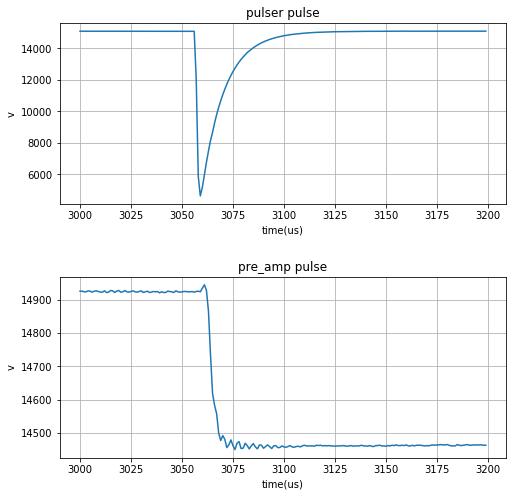

.....end......


In [75]:
V1724_1_pulse=read_event(filename,pulser_index[10],V1724_1_opch,V1724_1_twd)
#draw 
PlotRangeL=3000
PlotRangeH=3200

fig, ax = plt.subplots(2,1,figsize=(8,8))
ax[0].plot(list(range(V1724_1_twd)[PlotRangeL:PlotRangeH]), V1724_1_pulse[0][PlotRangeL:PlotRangeH])

ax[0].set(xlabel='time(us)', ylabel='v',
       title='pulser pulse')
ax[0].grid()
ax[1].plot(list(range(V1724_1_twd)[PlotRangeL:PlotRangeH]), V1724_1_pulse[1][PlotRangeL:PlotRangeH])

ax[1].set(xlabel='time(us)', ylabel='v',
       title='pre_amp pulse')
ax[1].grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.4)

plt.show()
        
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/pre_amp_pulser_1.png")#E:\CDEX\ovbb\WaveSimulation\figure   
#print(get_par(filename,10,V1724_1_opch,V1724_1_twd,get_risetime,[0.05,0.1,0.9,0.95]))
print(".....end......")

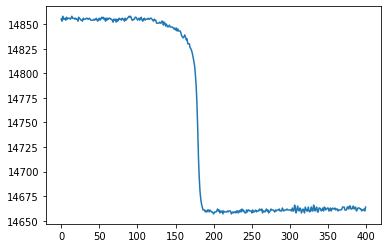

In [78]:
V1724_1_pulse=read_event(filename,7,V1724_1_opch,V1724_1_twd)
plt.plot(V1724_1_pulse[1][2600:3000])

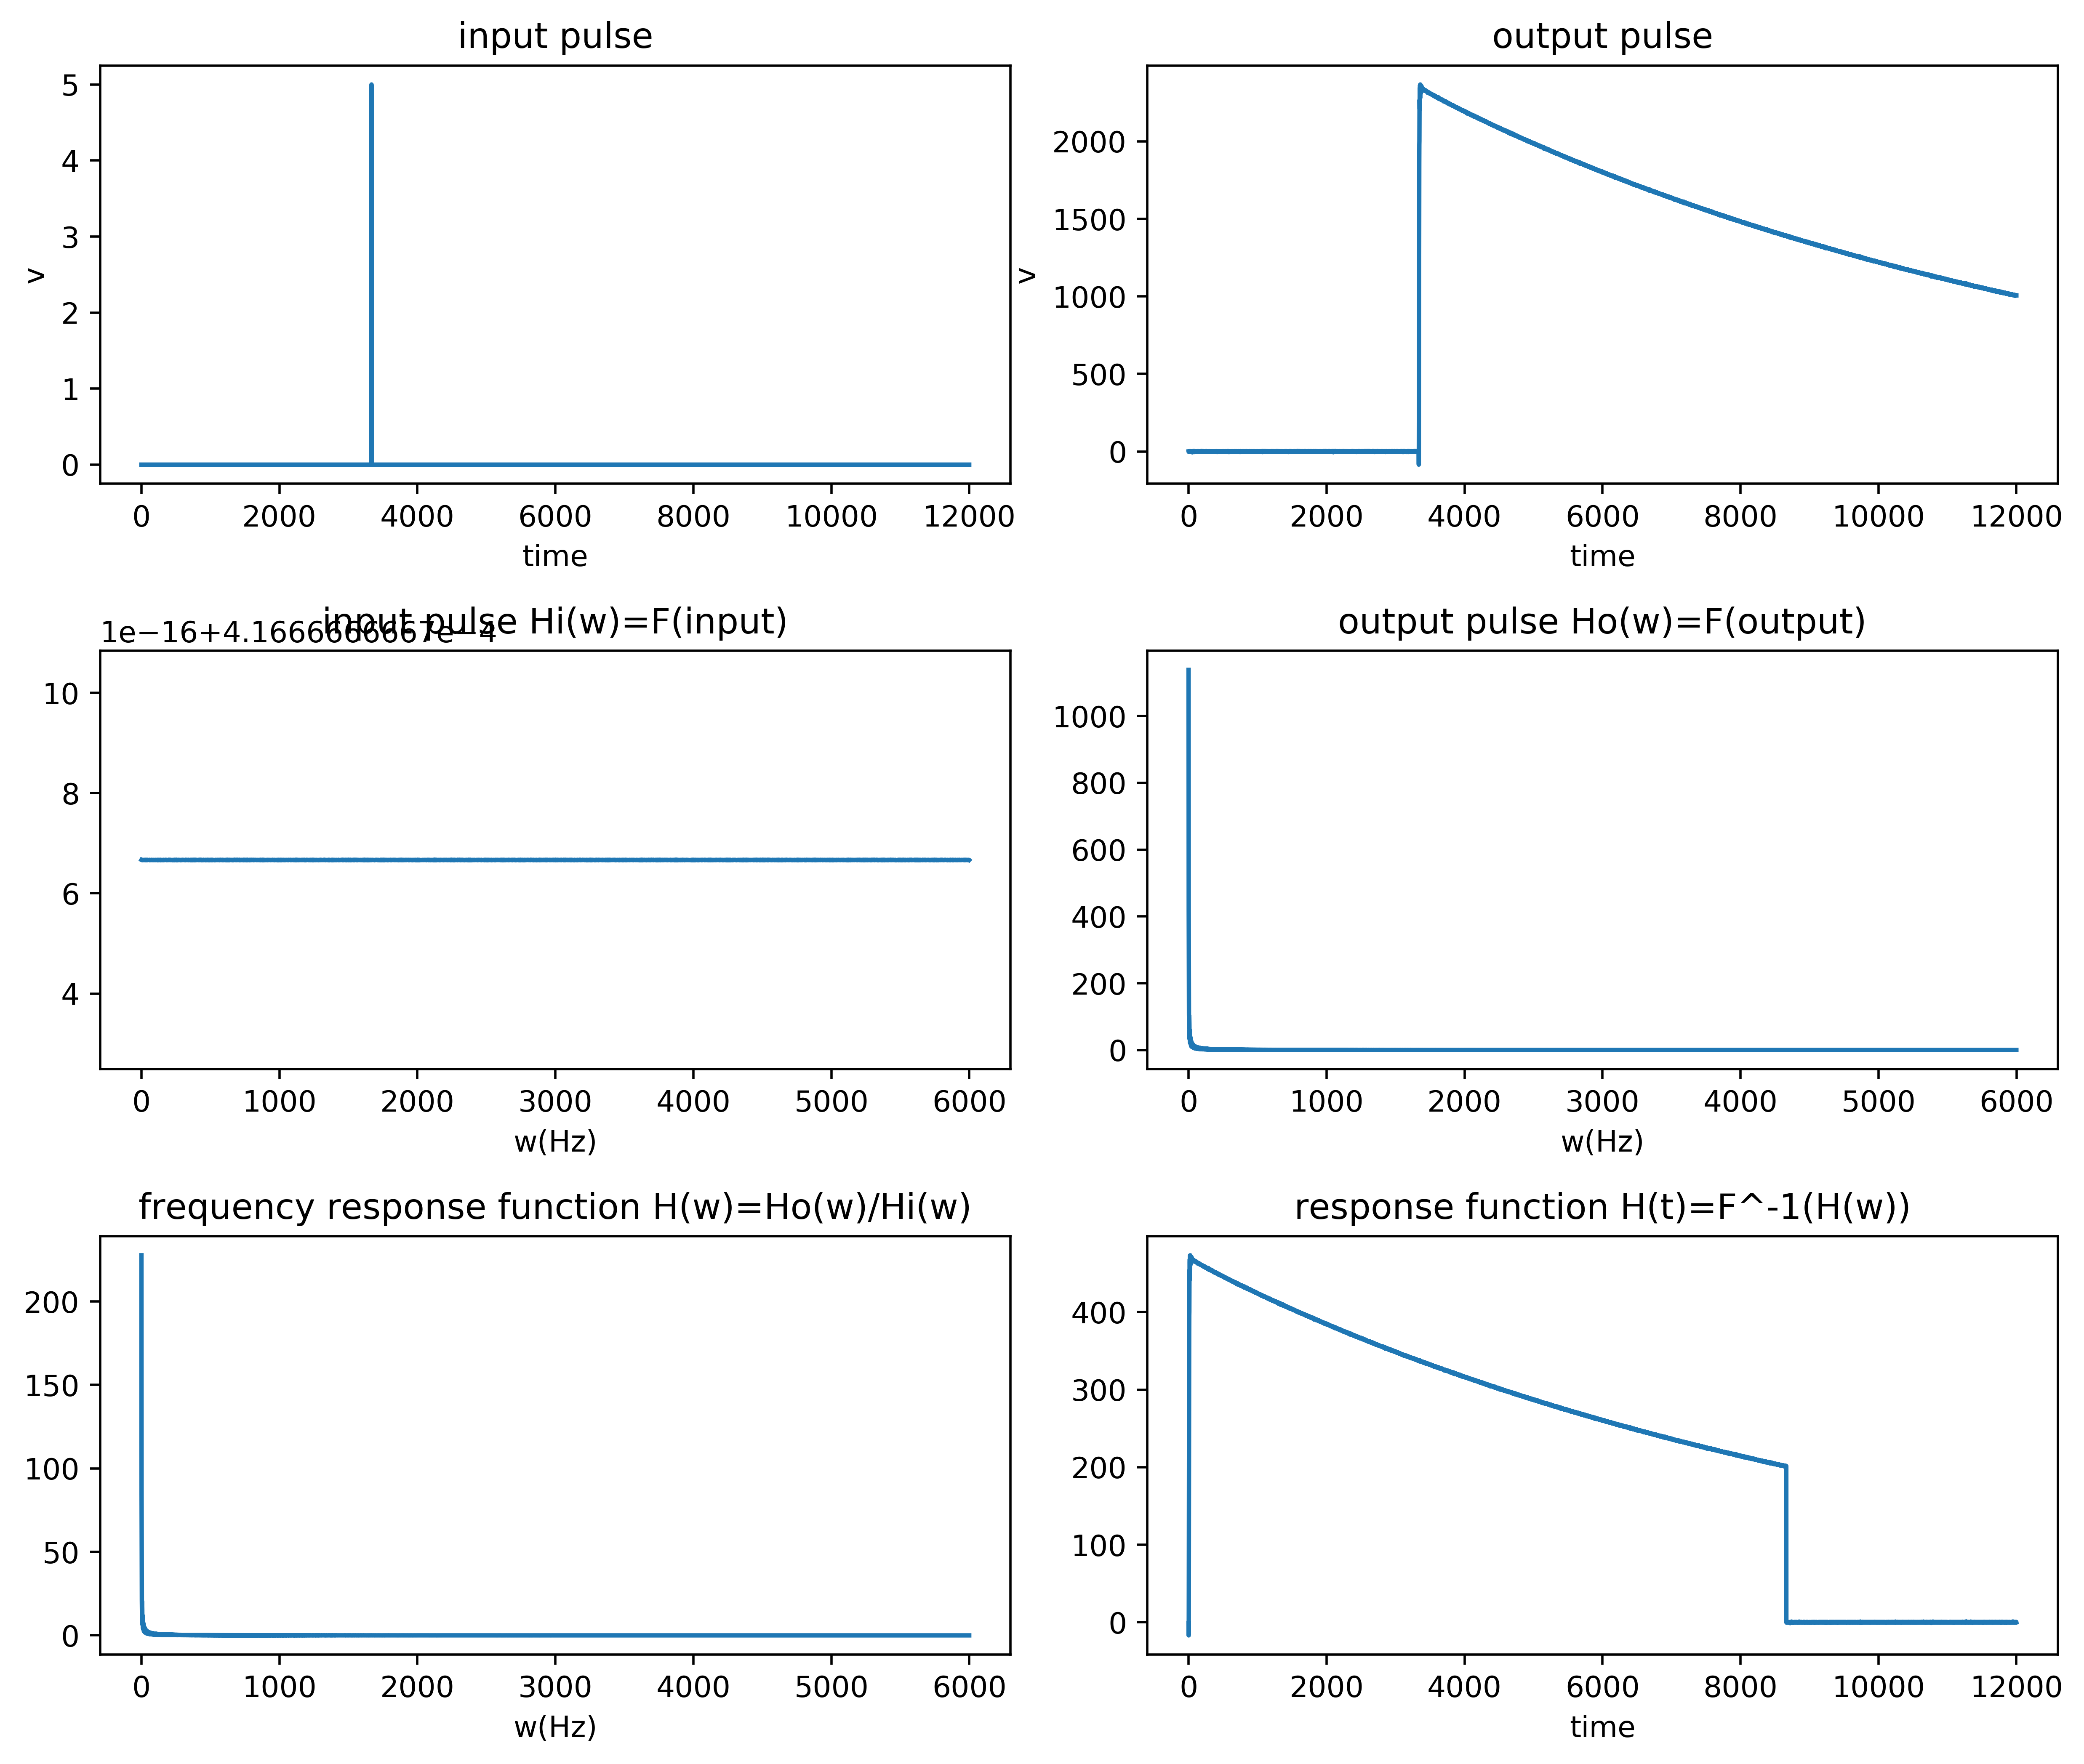

In [53]:
V1724_1_pulse=read_event(filename,1637,V1724_1_opch,V1724_1_twd)
#y_in=V1724_1_pulse[0][0:2000].mean()-V1724_1_pulse[0]
y_in=np.zeros((12000,),dtype=float)
y_in[3335]=5
y_out=V1724_1_pulse[1][0:2000].mean()-V1724_1_pulse[1]
#fft
t=(np.arange(12000)-3000)/1
x=np.exp(-t**2)
ffty_in=fft(y_in)
ffty_out=fft(y_out[0:12000])
HSfunc=ffty_out/ffty_in          # hit response function
abs_ffty_in=np.abs(ffty_in)
normal_ffty_in=abs_ffty_in[0:6000]/12000
normal_ffty_out=np.abs(ffty_out)[0:6000]/12000
abs_HSfunc=np.abs(HSfunc)
normal_HSfunc=abs_HSfunc[0:6000]/12000

fig, ax = plt.subplots(3,2,figsize=(12,10),dpi=500)
ax[0][0].plot(y_in)
ax[0][0].set(xlabel='time', ylabel='v',
       title='input pulse')
ax[0][1].plot(y_out)
ax[0][1].set(xlabel='time', ylabel='v',
       title='output pulse')

ax[1][0].plot(normal_ffty_in)
ax[1][0].set(xlabel='w(Hz)', ylabel='',
       title='input pulse Hi(w)=F(input)')
ax[1][1].plot(normal_ffty_out)
ax[1][1].set(xlabel='w(Hz)', ylabel='',
       title='output pulse Ho(w)=F(output)')

ax[2][0].plot(normal_HSfunc[0:6000])
ax[2][0].set(xlabel='w(Hz)', ylabel='',
       title='frequency response function H(w)=Ho(w)/Hi(w)')
ax[2][1].plot(ifft(HSfunc))
ax[2][1].set(xlabel='time', ylabel='',
       title='response function H(t)=F^-1(H(w))')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.15, hspace=0.4)
plt.show()
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/response func.png")
#print(ffty_in[1:3],ffty_out[1:3],HSfunc[1:3])

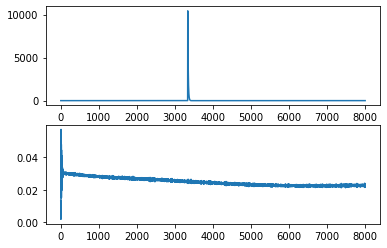

In [95]:
PlotRangeL=0
PlotRangeH=8000
t=(np.arange(12000)-3000)/50
x=np.exp(-t**2)


fftimput=fft(y_in)    #imput current signal 

                    #response function
fftoutput=HSfunc#*fftimput  #output 
output=ifft(fftoutput) 

#draw
fig, ax = plt.subplots(2,1)
ax[0].plot(y_in[PlotRangeL:PlotRangeH])
ax[1].plot(output[PlotRangeL:PlotRangeH])